# Amazon Customer Reviews Dataset
Amazon Customer Reviews (a.k.a. Product Reviews) is one of Amazon’s iconic products. In a period of over two decades since the first review in 1995, millions of Amazon customers have contributed over a hundred million reviews to express opinions and describe their experiences regarding products on the Amazon.com website. This makes Amazon Customer Reviews a rich source of information for academic researchers in the fields of Natural Language Processing (NLP), Information Retrieval (IR), and Machine Learning (ML), amongst others. Accordingly, we are releasing this data to further research in multiple disciplines related to understanding customer product experiences. Specifically, this dataset was constructed to represent a sample of customer evaluations and opinions, variation in the perception of a product across geographical regions, and promotional intent or bias in reviews.

    marketplace       - 2 letter country code of the marketplace where the review was written.
    customer_id       - Random identifier that can be used to aggregate reviews written by a single author.
    review_id         - The unique ID of the review.
    product_id        - The unique Product ID the review pertains to. In the multilingual dataset the reviews
                        for the same product in different countries can be grouped by the same product_id.
    product_parent    - Random identifier that can be used to aggregate reviews for the same product.
    product_title     - Title of the product.
    product_category  - Broad product category that can be used to group reviews 
                        (also used to group the dataset into coherent parts).
    star_rating       - The 1-5 star rating of the review.
    helpful_votes     - Number of helpful votes.
    total_votes       - Number of total votes the review received.
    vine              - Review was written as part of the Vine program.
    verified_purchase - The review is on a verified purchase.
    review_headline   - The title of the review.
    review_body       - The review text.
    review_date       - The date the review was written.

In [1]:
# Import standard libraries
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import dask.dataframe as dd
import sqlite3
from datetime import datetime
from collections import Counter

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline


# 1. EDA

## 1.1. Load in Data

In [2]:
amzn = pd.read_csv('datasets/amzn_vg_clean.csv')


In [3]:
amzn.drop(columns='Unnamed: 0', inplace=True)


In [4]:
print(amzn.shape)
amzn.sample(2)


(1781830, 15)


,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
1553444,US,31445316,R2BK2FPJNFXBKV,B000F5RW1U,957514695,Nyko Intercooler EX Cooling Fan for Xbox 360,Video Games,1,13,13,N,N,Killed my 360 aswell : /,"Stay away from this product, my intercooler, w...",2006-11-15
1762176,US,49354701,RSVTQP3VY89ZH,B00000K1AF,111865254,Mario Golf,Video Games,5,2,2,N,N,Playing golf has never been so much fun!,"When I first played this game, I knew next to ...",2000-08-24


In [5]:
# Check the values of our columns
amzn.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1781830 entries, 0 to 1781829
Data columns (total 15 columns):
marketplace          object
customer_id          int64
review_id            object
product_id           object
product_parent       int64
product_title        object
product_category     object
star_rating          int64
helpful_votes        int64
total_votes          int64
vine                 object
verified_purchase    object
review_headline      object
review_body          object
review_date          object
dtypes: int64(5), object(10)
memory usage: 203.9+ MB


In [6]:
# Check if there are any null values
amzn.isnull().sum()


marketplace          0
customer_id          0
review_id            0
product_id           0
product_parent       0
product_title        0
product_category     0
star_rating          0
helpful_votes        0
total_votes          0
vine                 0
verified_purchase    0
review_headline      0
review_body          0
review_date          0
dtype: int64

In [7]:
# Clean text in review body
# This can only be done here because doing so in the cleaning notebook and saving into a csv will cause errors
amzn['review_body'] = amzn['review_body'].apply(lambda x: x.replace(',','')\
                                                                 .replace('.','')\
                                                                 .replace('!','')\
                                                                 .replace('?','')\
                                                                 .replace(';','')\
                                                                 .replace('(','')\
                                                                 .replace(')','')\
                                                                 .replace('<br />','')\
                                                                 .replace('\\','')\
                                                                 .replace('&#34',''))


In [8]:
def check_matrix_sparsity(df):
    unique_users = df['customer_id'].nunique()
    unique_products = df['product_title'].nunique()

    print('No. of unique users: ', unique_users)
    print('No. of unique products: ', unique_products)
    print('Size of utility matrix: {} x {}; {} cells'.format(unique_users,
                                                             unique_products,
                                                             unique_users * unique_products))
    print('Sparsity: {:.3f}%'.format(len(df)/(unique_users * unique_products) * 100))

In [9]:
check_matrix_sparsity(amzn)

No. of unique users:  1043894
No. of unique products:  56169
Size of utility matrix: 1043894 x 56169; 58634482086 cells
Sparsity: 0.003%


## 1.2. Filtering out the Long Tail

It is important that we only keep customers who have reviewed enough products and products that have enough ratings.

In [10]:
print('Number of unique customers: ', len(amzn['customer_id'].unique()))
print('Number of unique products: ', len(amzn['product_id'].unique()))

Number of unique customers:  1043894
Number of unique products:  65717


In [11]:
amzn['customer_id'].value_counts().head(10)


52759271    909
42418272    856
45838740    839
24846840    614
24594001    459
40955995    459
48278407    439
27364030    361
30678701    326
50648042    301
Name: customer_id, dtype: int64

In [12]:
# A customer reviewed 909 products and could be a retailer
# Check if s/he is buying products in bulk
amzn[amzn['customer_id']==52759271]['product_title'].value_counts().head(15)


Lego Star Wars II: The Original Trilogy    5
Guitar Hero World Tour                     3
TimeSplitters 2                            3
Sega Superstars Tennis                     3
Guitar Hero 2                              3
Tom Clancy's Splinter Cell                 3
The Elder Scrolls IV: Oblivion             3
Guilty Gear X2                             2
Hitman 2 Silent Assassin                   2
Zoo Tycoon                                 2
The Hobbit                                 2
Gauntlet: Dark Legacy                      2
Star Wars Battlefront II                   2
Portal 2                                   2
Wii Sports Resort                          2
Name: product_title, dtype: int64

In [13]:
amzn[(amzn['customer_id']==52759271) & (amzn['product_title']=='Lego Star Wars II: The Original Trilogy')]

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
1557284,US,52759271,RYGU9U7K2EFSA,B000G7X0AO,518465393,Lego Star Wars II: The Original Trilogy,Video Games,5,24,26,N,N,Perfect Gaming Fun for All Ages,I loved the original Lego Star Wars game It wa...,2006-09-16
1557286,US,52759271,R3MWF67U459L36,B000FDOU9E,285187577,Lego Star Wars II: The Original Trilogy,Video Games,5,51,52,N,N,Great Gaming Fun for All Ages,I loved the original Lego Star Wars game It wa...,2006-09-16
1557295,US,52759271,R14IJMXUZ15WXY,B000FDMV9U,562399483,Lego Star Wars II: The Original Trilogy,Video Games,5,18,19,N,N,Great Gaming Fun for all ages,I loved the original Lego Star Wars game It wa...,2006-09-16
1557300,US,52759271,R3EL2786QL6W8U,B000FDDN2E,119000871,Lego Star Wars II: The Original Trilogy,Video Games,5,92,95,N,N,Great Fun for All Ages,I loved the original Lego Star Wars game It wa...,2006-09-16
1557305,US,52759271,RLKTOFBGLULY,B000FDKZCU,233160334,Lego Star Wars II: The Original Trilogy,Video Games,5,49,52,N,N,Great Gaming Fun for All Ages,I loved the original Lego Star Wars game It wa...,2006-09-16


In [14]:
# A customer reviewed 856 products and could be a retailer
# Check if s/he is buying products in bulk
amzn[amzn['customer_id']==42418272]['product_title'].value_counts().head(15)


Need For Speed: Most Wanted         8
Need for Speed: Carbon              7
Michael Jackson The Experience      6
Guitar Hero III: Legends of Rock    5
Nintendo DS Lite                    5
Rock Band                           4
Namco Museum 50th Anniversary       4
Sonic Mega Collection               4
Wii Messenger Bag                   3
Nintendo DS                         3
Sonic Riders                        3
Wii Play Controller                 3
Need For Speed: Underground 2       3
DS Nerf Triple Armor                3
Bejeweled 3                         3
Name: product_title, dtype: int64

**Insights:** The assumption made here is that a retailer would purchase products in bulk, whereas a casual buyer would only buy a small number of products. Upon inspection of the top 2 buyers with 909 and 856 orders each, we can deduce by the amount of each purchase that they are not retailers but are instead just big fans of video games.

In [15]:
# Look at quantiles
customers = amzn['customer_id'].value_counts()
products = amzn['product_id'].value_counts()


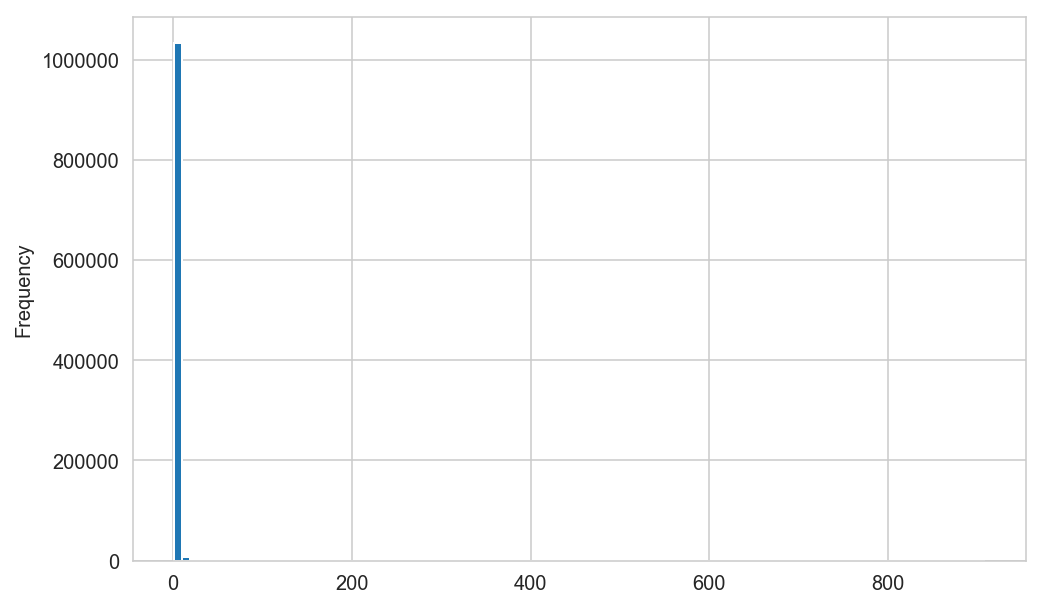

In [16]:
customers.plot(kind='hist', bins=100, figsize=(8,5))


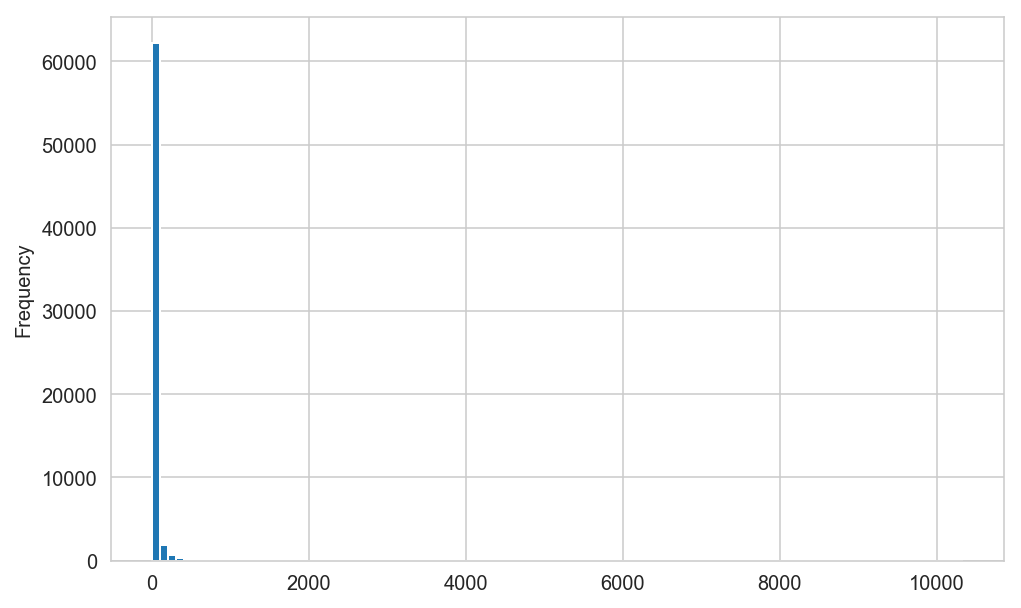

In [17]:
products.plot(kind='hist', bins=100, figsize=(8,5))

In [18]:
# Taking a look at the quantiles
quantiles = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.55, 0.6, 0.65, 0.7, 0.8, 0.9, 0.95, 0.96, 0.97, 0.98, 0.99, 1]
print('customers\n', customers.quantile(quantiles))
print('products\n', products.quantile(quantiles))

customers
 0.00      1.0
0.10      1.0
0.20      1.0
0.30      1.0
0.40      1.0
0.50      1.0
0.55      1.0
0.60      1.0
0.65      1.0
0.70      1.0
0.80      2.0
0.90      3.0
0.95      4.0
0.96      5.0
0.97      6.0
0.98      7.0
0.99     11.0
1.00    909.0
Name: customer_id, dtype: float64
products
 0.00        1.00
0.10        1.00
0.20        1.00
0.30        2.00
0.40        2.00
0.50        4.00
0.55        5.00
0.60        7.00
0.65        9.00
0.70       12.00
0.80       23.00
0.90       55.00
0.95      111.00
0.96      136.00
0.97      176.00
0.98      246.68
0.99      396.84
1.00    10335.00
Name: product_id, dtype: float64


**Insights:** Only about 4% of customers have rated 5 or more video game products, and only 35% of video game products have been rated by 9+ customers. This effect creates a long tail in our histograms of customers and products, seen above. 

In [19]:
# Filtering out the long tail.
customers = customers[customers >= 5]
# customers = customers[customers <= 300]
products = products[products >= 400]

amzn = amzn.merge(pd.DataFrame({'customer_id': customers.index}))
amzn = amzn.merge(pd.DataFrame({'product_id': products.index}))

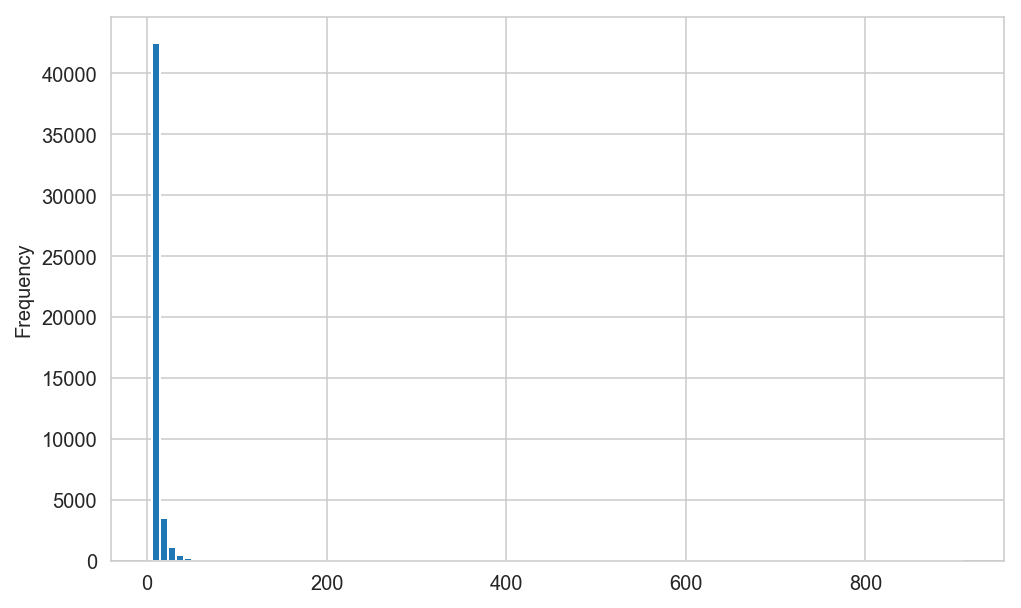

In [20]:
customers.plot(kind='hist', bins=100, figsize=(8,5))

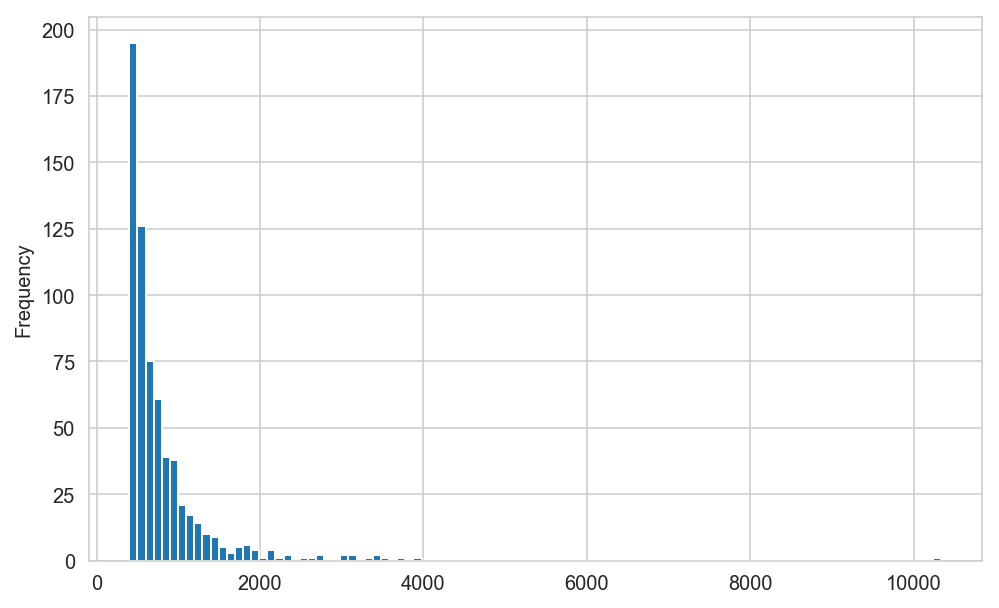

In [21]:
products.plot(kind='hist', bins=100, figsize=(8,5))

In [22]:
amzn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118497 entries, 0 to 118496
Data columns (total 15 columns):
marketplace          118497 non-null object
customer_id          118497 non-null int64
review_id            118497 non-null object
product_id           118497 non-null object
product_parent       118497 non-null int64
product_title        118497 non-null object
product_category     118497 non-null object
star_rating          118497 non-null int64
helpful_votes        118497 non-null int64
total_votes          118497 non-null int64
vine                 118497 non-null object
verified_purchase    118497 non-null object
review_headline      118497 non-null object
review_body          118497 non-null object
review_date          118497 non-null object
dtypes: int64(5), object(10)
memory usage: 14.5+ MB


### 1.3. Filtering Out Non-Video-Game Items

In [23]:
print(len(amzn['product_title'].unique()))


549


In [24]:
for item in amzn['product_title'].unique():
    print(item)
    

Bloodborne
Battlefield 4
PlayStation 4 Camera (Old Model)
Far Cry 3
Super Smash Brothers
Valkyria Chronicles
16GB PlayStation Vita Memory Card
Pokemon Y
Battlefield 3
Call of Duty: Modern Warfare 2
Call of Duty: Black Ops
Xbox 360 Black Play and Charge Kit
Grand Theft Auto IV
Halo 3
Xbox One Play and Charge Kit
Retrolink Nintendo 64 Classic USB Enabled Wired Controller for PC and MAC, Black
Official Nintendo White Classic Gamecube Controller
Turtle Beach Ear Force X12 Arctic Amplified Stereo Gaming Headset - Xbox 360
Halo Reach
DualShock 3 Wireless Controller
The Last of Us
Tomb Raider
God of War: Ascension
Xbox One Console - Titanfall + Kinect
Pokémon Black Version 2
Luigi's Mansion: Dark Moon
Resident Evil 6
PS3 God of War: Saga Collection - 2 Disc
PlayStation 4 500GB Console [Old Model]
Xbox 360 4GB Console
Hyrule Warriors
Nintendo 3DS Aqua Blue
Disney Epic Mickey
PS3 250GB Uncharted 3: Game of the Year Bundle
Red Dead Redemption Game of the Year
POWER A Charger
Zumba Fitness Rush -

In [25]:
def get_non_vg(item_list):
    '''
    Function that returns a list of non-video-game items.
    '''
    non_vg_list = []
    
    for item in item_list:
        # Specific keywords
        if 'vita' in item.lower() or 'wii' in item.lower() or 'kinect' in item.lower():
            non_vg_list.append(item)
        elif 'camera' in item.lower() or 'kit' in item.lower() or 'card' in item.lower():
            non_vg_list.append(item)
        elif 'accessor' in item.lower() or 'controller' in item.lower() or 'nyko' in item.lower():
            non_vg_list.append(item)
        elif 'pad' in item.lower() or 'gamepad' in item.lower() or 'dualshock' in item.lower():
            non_vg_list.append(item)
        elif 'points card' in item.lower() or 'disk' in item.lower() or 'case' in item.lower():
            non_vg_list.append(item)
        elif 'wireless' in item.lower() or 'battery' in item.lower() or 'adapt' in item.lower():
            non_vg_list.append(item)
        elif 'cable' in item.lower() or 'cord' in item.lower() or 'usb' in item.lower():
            non_vg_list.append(item)
        elif 'stick' in item.lower() or 'fightstick' in item.lower() or 'sensor' in item.lower():
            non_vg_list.append(item)
        elif 'wheel' in item.lower() or 'headset' in item.lower() or 'headphone' in item.lower():
            non_vg_list.append(item)
        elif 'processor' in item.lower() or 'system' in item.lower() or 'cooler' in item.lower():
            non_vg_list.append(item)
        elif 'portable' in item.lower() or 'charg' in item.lower() or 'gb' in item.lower():
            non_vg_list.append(item)
        elif 'decal' in item.lower() or 'hack' in item.lower() or 'stand' in item.lower():
            non_vg_list.append(item)
        elif 'screwdriver' in item.lower() or 'touch pen' in item.lower() or 'gaming' in item.lower():
            non_vg_list.append(item)
        elif 'protect' in item.lower() or 'thrustmaster' in item.lower() or 'grip' in item.lower():
            non_vg_list.append(item)
        elif 'cover' in item.lower() or 'button' in item.lower() or 'blizzard' in item.lower():
            non_vg_list.append(item)
        elif 'console' in item.lower() or 'analog' in item.lower() or 'skin set' in item.lower():
            non_vg_list.append(item)
        elif 'glasses' in item.lower() or 'nvidia' in item.lower() or 'kontrolfreek' in item.lower():
            non_vg_list.append(item)
        elif 'action replay' in item.lower() or 'stylus' in item.lower() or 'mixer' in item.lower():
            non_vg_list.append(item)
        elif 'pak' in item.lower() or 'pearl pink' in item.lower() or 'playstation eye' in item.lower(): 
            non_vg_list.append(item)
        elif 'trigger' in item.lower() or 'plantronics' in item.lower() or 'expansion bar' in item.lower():
            non_vg_list.append(item)
        elif 'playstation move' in item.lower() or 'thrustmaster' in item.lower() or 'action reply' in item.lower():
            non_vg_list.append(item)
        elif 'invisi-shield' in item.lower() or 'cartridge' in item.lower() or 'bag' in item.lower():
            non_vg_list.append(item)
        elif 'head set' in item.lower() or 'remote' in item.lower() or 'music mixer' in item.lower():
            non_vg_list.append(item)
        elif 'dreamcast' in item.lower() or 'pack' in item.lower() or 'essentials' in item.lower():
            non_vg_list.append(item)
        elif 'lcd' in item.lower() or 'screen' in item.lower() or 'pocket' in item.lower():
            non_vg_list.append(item)
        elif 'logitech' in item.lower() or 'intec' in item.lower() or 'cooling' in item.lower():
            non_vg_list.append(item)
        elif 'thumbstick' in item.lower() or 'joystick' in item.lower() or 'power supply' in item.lower():
            non_vg_list.append(item)
        elif 'figur' in item.lower() or 'dingoo' in item.lower() or 'emulator' in item.lower():
            non_vg_list.append(item)
        elif 'gamedr' in item.lower() or 'tool' in item.lower() or 'power disk' in item.lower():
            non_vg_list.append(item)
        elif 'tote' in item.lower() or 'combo' in item.lower() or 'poster' in item.lower():
            non_vg_list.append(item)
        elif 'bundle' in item.lower() or 'multi-reader' in item.lower() or 'enhancer' in item.lower():
            non_vg_list.append(item)
        elif 'resolution' in item.lower() or 'visual' in item.lower() or 'skylanders' in item.lower():
            non_vg_list.append(item)
        elif 'turtle beach' in item.lower() or 'microphone' in item.lower() or 'insten' in item.lower():
            non_vg_list.append(item)
        elif 'warbeast guitar' in item.lower() or 'umd' in item.lower() or 'faceplate' in item.lower():
            non_vg_list.append(item)
        elif 'eyewear' in item.lower() or 'silicon' in item.lower() or 'mountain dew' in item.lower():
            non_vg_list.append(item)
        elif 'xcm' in item.lower() or 'dsi' in item.lower() or '3dsll' in item.lower():
            non_vg_list.append(item)
        elif 'pedal plate' in item.lower() or 'ottoman' in item.lower() or 'audio' in item.lower():
            non_vg_list.append(item)
        elif 'replacement' in item.lower() or 'artbook' in item.lower() or 'bluray' in item.lower():
            non_vg_list.append(item)
        elif 'filter' in item.lower() or 'doll' in item.lower() or 'plush' in item.lower():
            non_vg_list.append(item)
        elif 'game traveler' in item.lower() or 'dongle' in item.lower() or 'keyboard' in item.lower():
            non_vg_list.append(item)
        elif 'blackhead' in item.lower() or 'handheld' in item.lower() or 'lime' in item.lower():
            non_vg_list.append(item)
        elif 'batter' in item.lower() or 'slim' in item.lower() or 'lens' in item.lower():
            non_vg_list.append(item)
        elif 'enteractive' in item.lower() or 'blu-ray' in item.lower() or 'email' in item.lower():
            non_vg_list.append(item)
        elif 'trial' in item.lower() or 'clock' in item.lower() or 'cpu' in item.lower():
            non_vg_list.append(item)
        elif 'latex' in item.lower() or 'install' in item.lower() or 'gdr' in item.lower():
            non_vg_list.append(item)
        elif 'light bar' in item.lower() or 'modulator' in item.lower() or 'drum' in item.lower():
            non_vg_list.append(item)
        elif 'hdmi' in item.lower() or 'gift' in item.lower() or 'game chamber' in item.lower():
            non_vg_list.append(item)
        elif 'nerf' in item.lower() or 'xl' in item.lower() or 'udraw' in item.lower():
            non_vg_list.append(item)
        elif 'cronusmax' in item.lower() or 'disc' in item.lower() or 'phone' in item.lower():
            non_vg_list.append(item)
        elif 'subscript' in item.lower() or 'simulat' in item.lower() or 'grip' in item.lower():
            non_vg_list.append(item)
        elif 'code' in item.lower() or 'crystal red' in item.lower() or 'sea green' in item.lower():
            non_vg_list.append(item)
        elif 'snakebyte' in item.lower() or 'dvd' in item.lower() or 'metallic blue' in item.lower():
            non_vg_list.append(item)
        elif 'arcade' in item.lower() or 'gioteck' in item.lower() or 'simulat' in item.lower():
            non_vg_list.append(item)
        elif 'dock' in item.lower() or 'mat' in item.lower() or 'hard drive' in item.lower():
            non_vg_list.append(item)
        elif 'fan' in item.lower() or 'pdp' in item.lower() or 'afterglow' in item.lower():
            non_vg_list.append(item)
        elif 'playgear' in item.lower() or 'mustang' in item.lower() or 'evo' in item.lower():
            non_vg_list.append(item)
        elif 'toshiba' in item.lower() or 'samsung' in item.lower() or 'import' in item.lower():
            non_vg_list.append(item)
        elif 'aqua blue' in item.lower() or '$' in item.lower() or 'dreamgear' in item.lower():
            non_vg_list.append(item)
        elif 'trimount' in item.lower() or 'trenro' in item.lower() or 'move battle' in item.lower():
            non_vg_list.append(item)
        elif 'cosmo black' in item.lower() or 'pspgo' in item.lower() or 'lite' in item.lower(): 
            non_vg_list.append(item)
        elif 'disney' in item.lower() or 'gamecube' in item.lower() or 'anthology' in item.lower():
            non_vg_list.append(item)
        
        # Specific items
        elif item.lower()=='playstation 2' or item.lower()=='nintendo 3ds xl' or item.lower()=='gameboy advance sp':
            non_vg_list.append(item)
        elif item.lower()=='gc-wrnsc' or item.lower()=='nintendo 2ds xl' or item.lower()=='playstation 3 5-in-1':
            non_vg_list.append(item)
        elif item.lower()=='nintendo 3ds 11-in-1 starter pack' or item.lower()=='funko 6" santa jack skellington':
            non_vg_list.append(item)
        elif item.lower()=='nintendo game boy advance sp ags-101 onyx black' or item.lower()=='3.8mm game bit driver':
            non_vg_list.append(item)
        elif item.lower()=='sony twisted metal: black - playstation 2' or item.lower()=='nintendo 2ds':
            non_vg_list.append(item)
        elif item.lower()=='playstation 3' or item.lower()=='ps3 media hub +':
            non_vg_list.append(item)
        
    return non_vg_list


In [26]:
non_vg_list = get_non_vg(amzn['product_title'].unique())
amzn.drop(amzn[amzn['product_title'].isin(non_vg_list)].index, inplace=True)
print(amzn.shape)
print('products lost:', len(non_vg_list))
print('products kept:', len(amzn['product_title'].unique()))


(72210, 15)
products lost: 291
products kept: 258


### 1.4. Filtering Out Old Games

In [27]:
# Some entries are very old. Let's filter these out as it is unlikely 
# that we will be recommending a 2002 game to someone in 2014.
# The threshold shall be 2008

# Add column for year and month
amzn['year_month'] = amzn['review_date'].apply(lambda x: x[:7])
amzn['year_month'] = pd.to_datetime(amzn['year_month'], format='%Y/%m')

amzn['review_date'] = pd.to_datetime(amzn['review_date'])
amzn['year'] = amzn['review_date'].apply(lambda x: x.year)
amzn['month'] = amzn['review_date'].apply(lambda x: x.month)

amzn.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,year_month,year,month
0,US,10712640,R1Q5VYCTPXRST1,B00KVR4HEC,558590596,Bloodborne,Video Games,5,0,0,N,Y,Five Stars,The best game available on ps4 and one of the ...,2015-08-31,2015-08-01,2015,8
1,US,37495299,R1N8IOE3RFD0C1,B00KVR4HEC,558590596,Bloodborne,Video Games,5,0,0,N,Y,Great for hardcore gamers,Best ps4 exclusive Not for a casual gamer though,2015-08-31,2015-08-01,2015,8
2,US,40751777,RUPOO0GC538JR,B00KVR4HEC,558590596,Bloodborne,Video Games,4,39,52,N,N,An Old Dog.,When I was in college I adopted a cranky old s...,2015-03-24,2015-03-01,2015,3
3,US,15123150,R1VV1FAEHAQDTQ,B00KVR4HEC,558590596,Bloodborne,Video Games,5,0,0,N,N,The most fun I've had on my PS4.,Until this game I wasn't really wowed by any o...,2015-05-02,2015-05-01,2015,5
4,US,13851096,R2PIY7GMCRCY7E,B00KVR4HEC,558590596,Bloodborne,Video Games,5,2,5,N,Y,Instant classic,Complaint: It's too hard Solution: Maybe th...,2015-03-28,2015-03-01,2015,3


In [28]:
print(amzn[amzn['year'] >= 2010].shape)
print(amzn.shape)

(61409, 18)
(72210, 18)


In [29]:
amzn.drop(amzn[amzn['year'] < 2010].index, inplace=True)

In [30]:
print(len(amzn['product_title'].unique()))

258


### 1.5 Filtering Out (Too) New Games

In [31]:
def remove_new_items_users(df, test_year=2014):
    '''
    Function which returns a dataframe without products 
    and users who only appear past the test year.
    
    Arguments:
    - df         :   Full dataframe
    - test_year  :   Year that users and products will be tested in
    
    Returns:
    - df   :   Dataframe without new users and products
    '''
    df['year'] = df['review_date'].apply(lambda x: x.year)
    
    user_start = df.groupby('customer_id')[['year']].min()
    df = df[df['customer_id'].isin(user_start[user_start['year'] < test_year].index)]
    
    product_start = df.groupby('product_title')[['year']].min()
    df = df[df['product_title'].isin(product_start[product_start['year'] < test_year].index)]
    
    return df

In [32]:
amzn.shape

(61409, 18)

In [33]:
amzn = remove_new_items_users(amzn, test_year=2014)
amzn.shape

(33435, 18)

In [34]:
print(len(amzn['product_title'].unique()))

221


## 2. EDA Proper

In [35]:
amzn.shape


(33435, 18)

In [36]:
amzn.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 33435 entries, 267 to 118364
Data columns (total 18 columns):
marketplace          33435 non-null object
customer_id          33435 non-null int64
review_id            33435 non-null object
product_id           33435 non-null object
product_parent       33435 non-null int64
product_title        33435 non-null object
product_category     33435 non-null object
star_rating          33435 non-null int64
helpful_votes        33435 non-null int64
total_votes          33435 non-null int64
vine                 33435 non-null object
verified_purchase    33435 non-null object
review_headline      33435 non-null object
review_body          33435 non-null object
review_date          33435 non-null datetime64[ns]
year_month           33435 non-null datetime64[ns]
year                 33435 non-null int64
month                33435 non-null int64
dtypes: datetime64[ns](2), int64(7), object(9)
memory usage: 4.8+ MB


### 2.1. Customers

In [37]:
cust_id_vc = amzn['customer_id'].value_counts(ascending=True)
top_customers = cust_id_vc.tail(10)
top_customers

52125818    30
45261517    30
42010198    32
47956883    33
46325819    33
51310953    38
23824641    39
14000007    45
40955995    54
24594001    56
Name: customer_id, dtype: int64

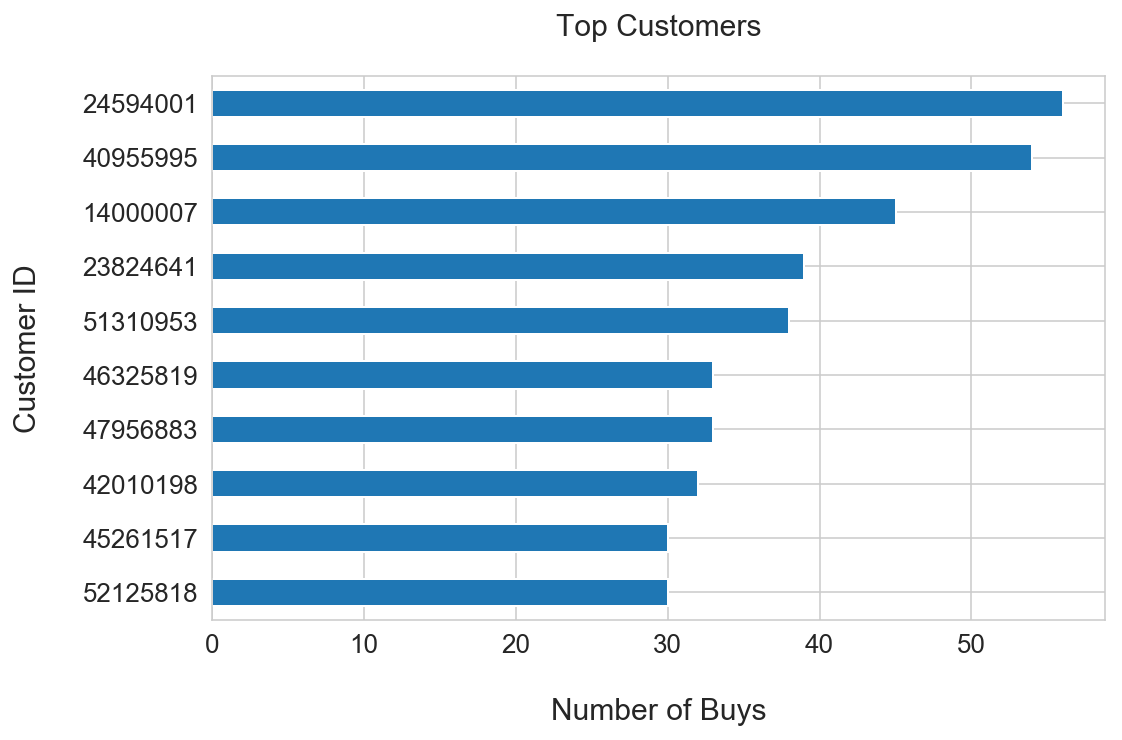

In [38]:
# Plot
top_customers.plot(kind='barh', figsize=(8,5))
plt.title('Top Customers', pad=20, fontsize=15)
plt.xlabel('Number of Buys', labelpad=20, fontsize=15)
plt.ylabel('Customer ID', labelpad=20, fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()

### 2.2. Ratings

In [39]:
# Look at the value counts of the ratings
amzn['star_rating'].value_counts()

5    19344
4     6293
3     3521
1     2437
2     1840
Name: star_rating, dtype: int64

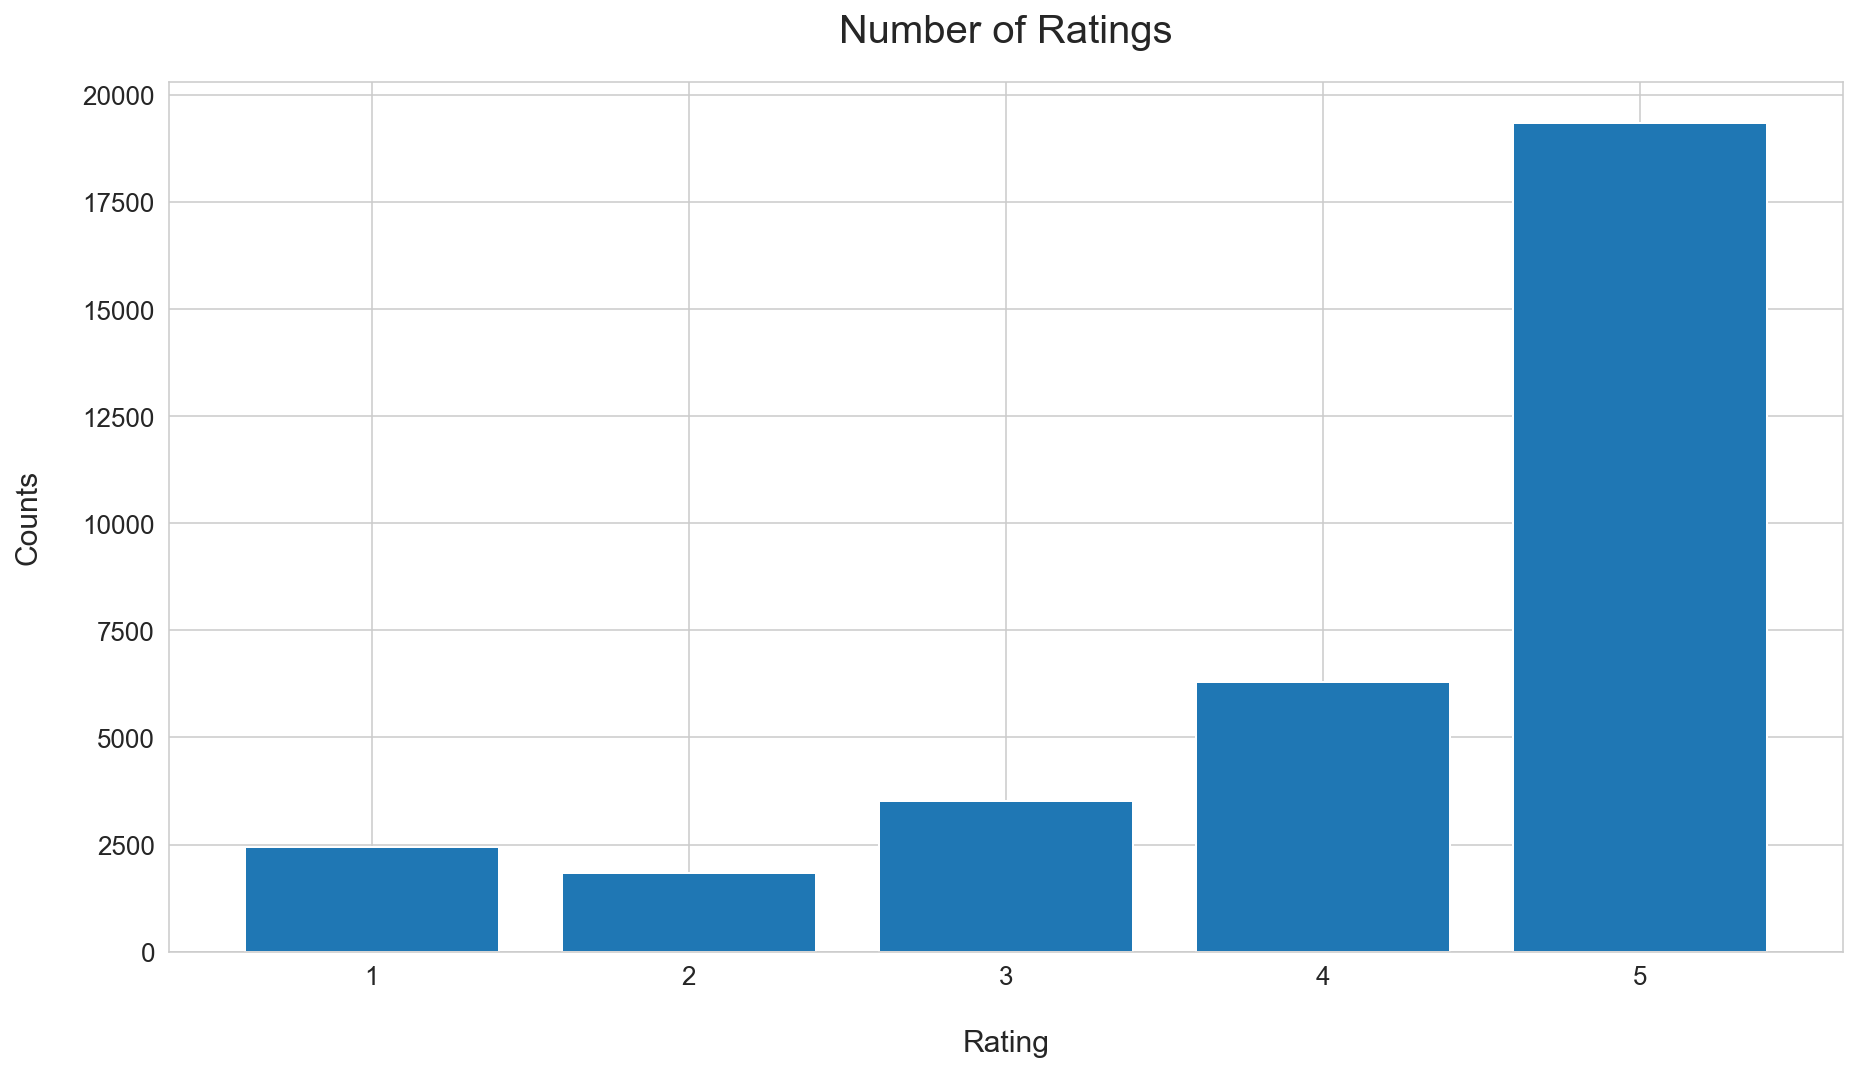

In [40]:
# Plot the value counts of the ratings
ratings = amzn['star_rating'].value_counts().reset_index()
ratings.sort_values(by='index', ascending=False, inplace=True)
# ratings

plt.figure(figsize=(15,8))
plt.bar(ratings['index'], ratings['star_rating'])
plt.title('Number of Ratings', pad=20, fontsize=20)
plt.xlabel('Rating', labelpad=20, fontsize=15)
plt.ylabel('Counts', labelpad=20, fontsize=15)
plt.xticks(rotation=0, fontsize=13)
plt.yticks(fontsize=13)
plt.show()

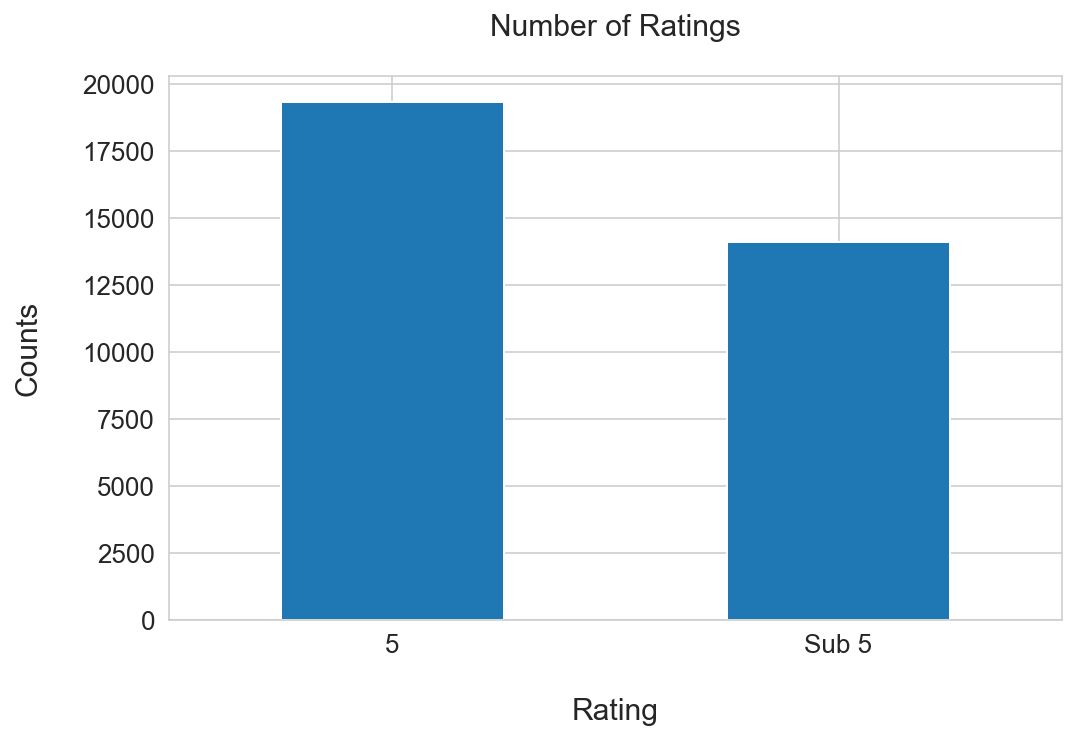

In [41]:
# Combine ratings below 5 into 1
amzn['is_5_star'] = amzn['star_rating'].apply(lambda x: 1 if x==5 else 0)
is_5_star = amzn['is_5_star'].value_counts()

is_5_star.plot(kind='bar', figsize=(8,5))
plt.title('Number of Ratings', pad=20, fontsize=15)
plt.xlabel('Rating', labelpad=20, fontsize=15)
plt.ylabel('Counts', labelpad=20, fontsize=15)
plt.xticks(ticks=range(0,2), labels=['5','Sub 5'], rotation=0, fontsize=13)
plt.yticks(fontsize=13)
plt.show()

### 2.4. Product Titles

**Popular Games**

In [42]:
# Look at the value counts of the product titles
prod_title_vc = amzn['product_title'].value_counts()
print(prod_title_vc.shape)
prod_title_vc.head(10)

(221,)


Elder Scrolls V: Skyrim    853
Battlefield 3              736
The Last of Us             723
Grand Theft Auto V         723
Call of Duty: Ghosts       630
Assassin's Creed III       553
Assassin's Creed 4         536
Red Dead Redemption        486
Halo 4                     479
Tomb Raider                446
Name: product_title, dtype: int64

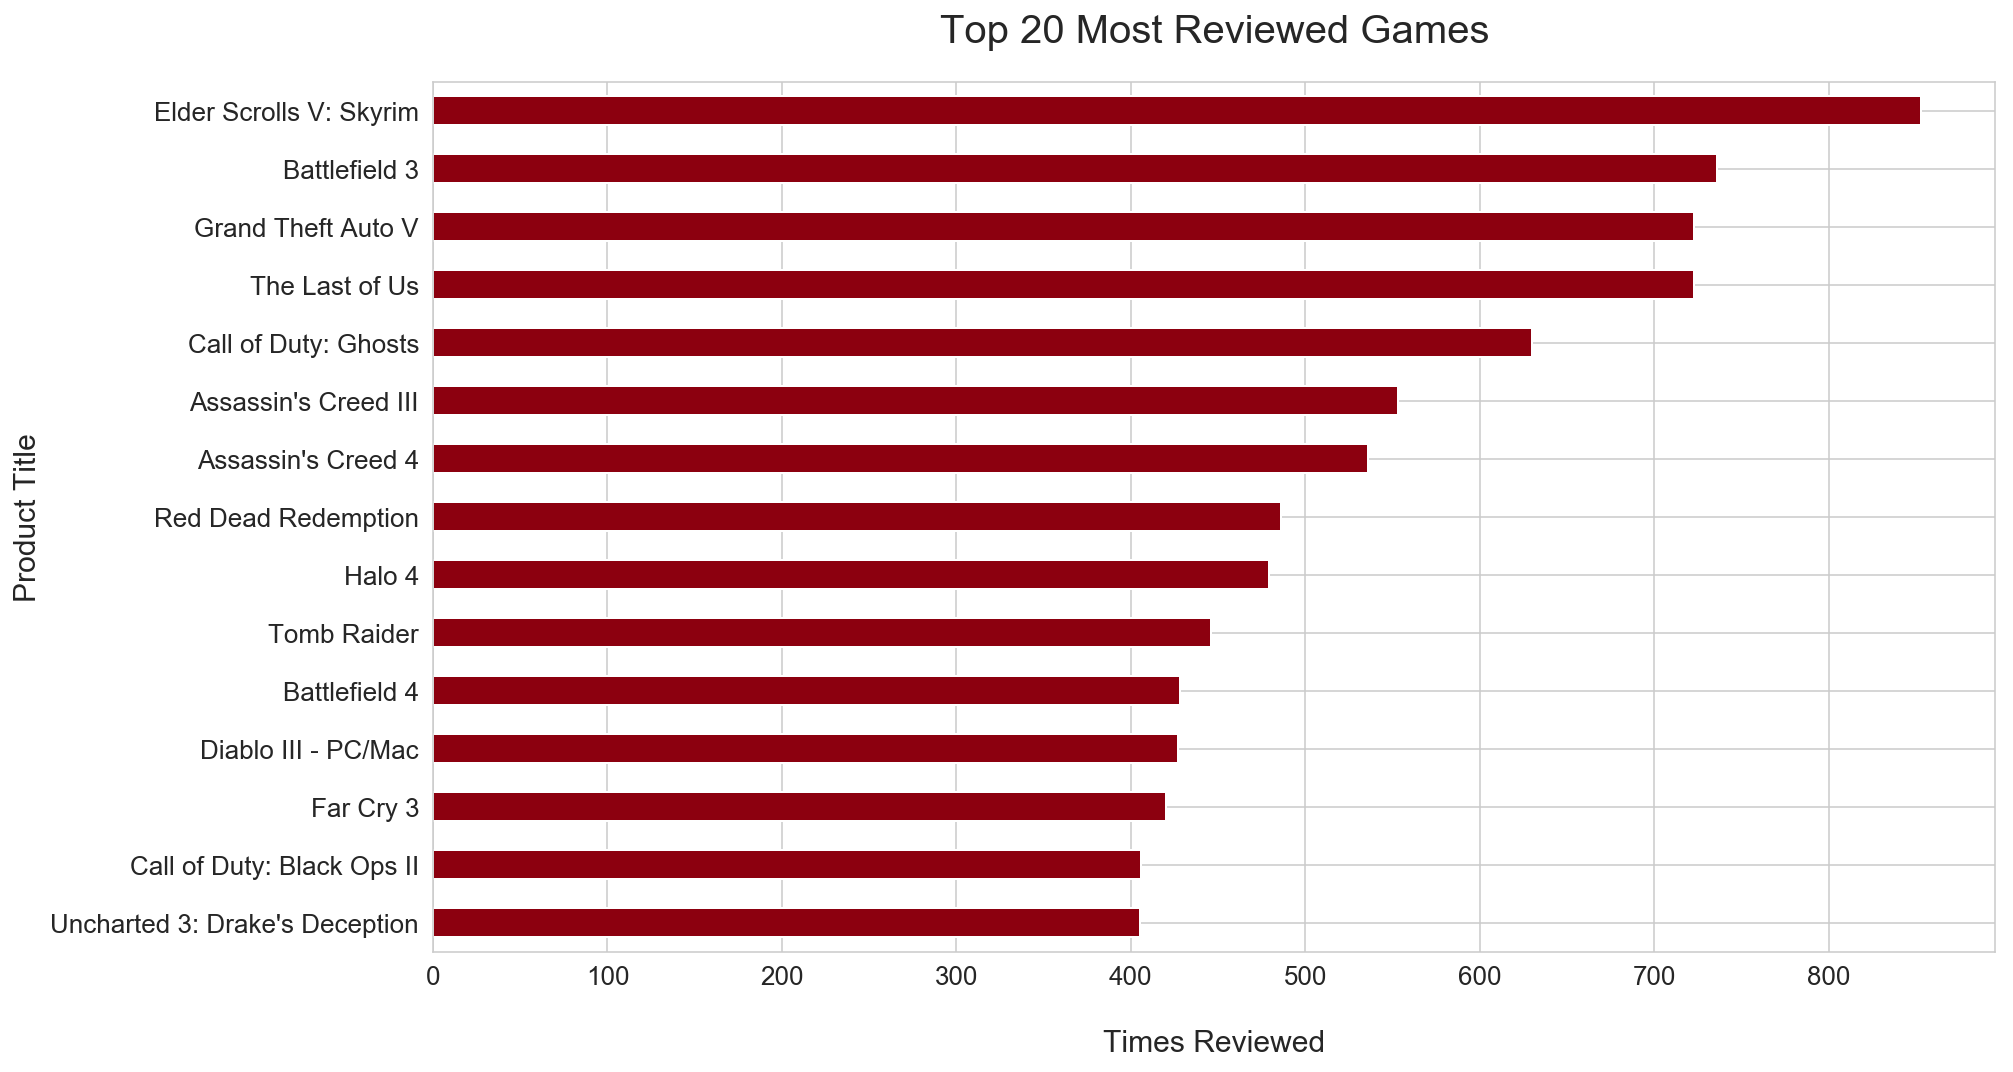

In [43]:
# Plot the value counts of the 20 most popular items
prod_pop = prod_title_vc.head(15).sort_values(ascending=True)

prod_pop.plot(kind='barh', figsize=(14,8), color='#8c000f')
plt.title('Top 20 Most Reviewed Games', pad=20, fontsize=20)
plt.xlabel('Times Reviewed', labelpad=20, fontsize=15)
plt.ylabel('Product Title', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()


In [44]:
top5_mostreviewed = amzn.groupby('product_title')['star_rating']\
                   .value_counts()[['Elder Scrolls V: Skyrim',
                                    'Battlefield 3',
                                    'The Last of Us',
                                    'Grand Theft Auto V',
                                    'Call of Duty: Ghosts']].unstack().sort_values(by=5, ascending=True)
top5_mostreviewed


star_rating,1,2,3,4,5
product_title,,,,,
Call of Duty: Ghosts,138,97,101,105,189
Battlefield 3,93,60,96,160,327
Grand Theft Auto V,37,27,58,103,498
Elder Scrolls V: Skyrim,80,35,64,118,556
The Last of Us,21,22,40,76,564


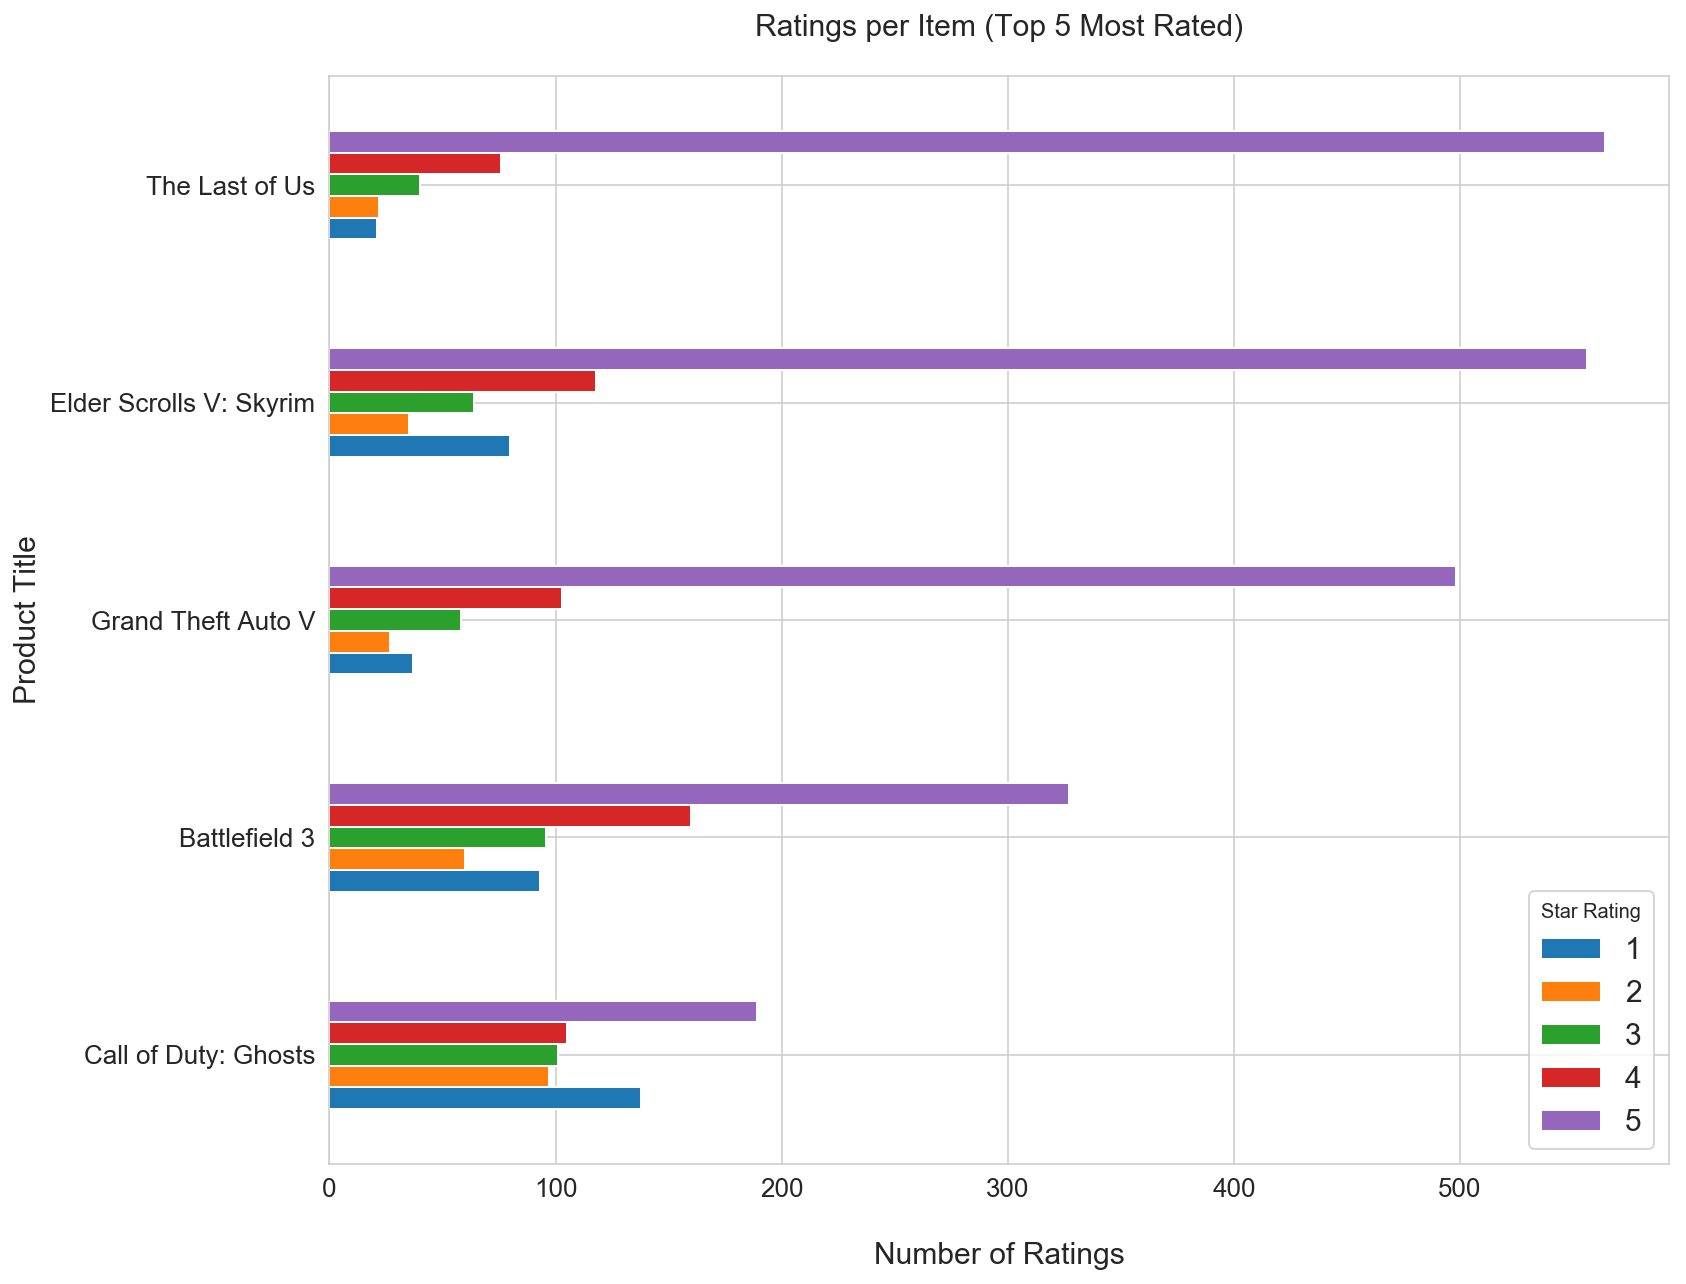

In [45]:
top5_mostreviewed.plot(kind='barh', figsize=(12,10))
plt.title('Ratings per Item (Top 5 Most Rated)', pad=20, fontsize=15)
plt.xlabel('Number of Ratings', labelpad=20, fontsize=15)
plt.ylabel('Product Title', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(title='Star Rating', prop={'size': 15})
plt.show()


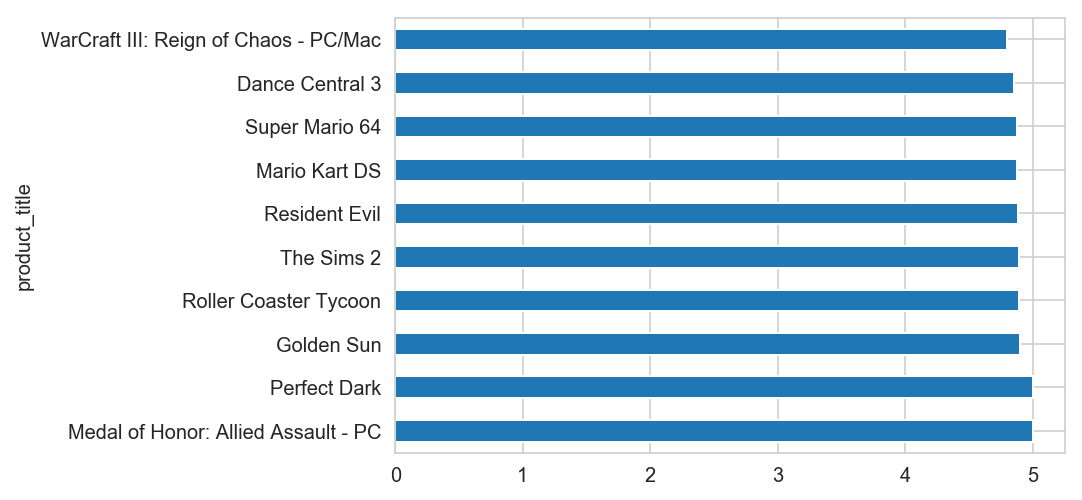

In [46]:
amzn.groupby('product_title')['star_rating'].mean().sort_values(ascending=False).head(10).plot(kind='barh')

### 2.5. Date Reviewed

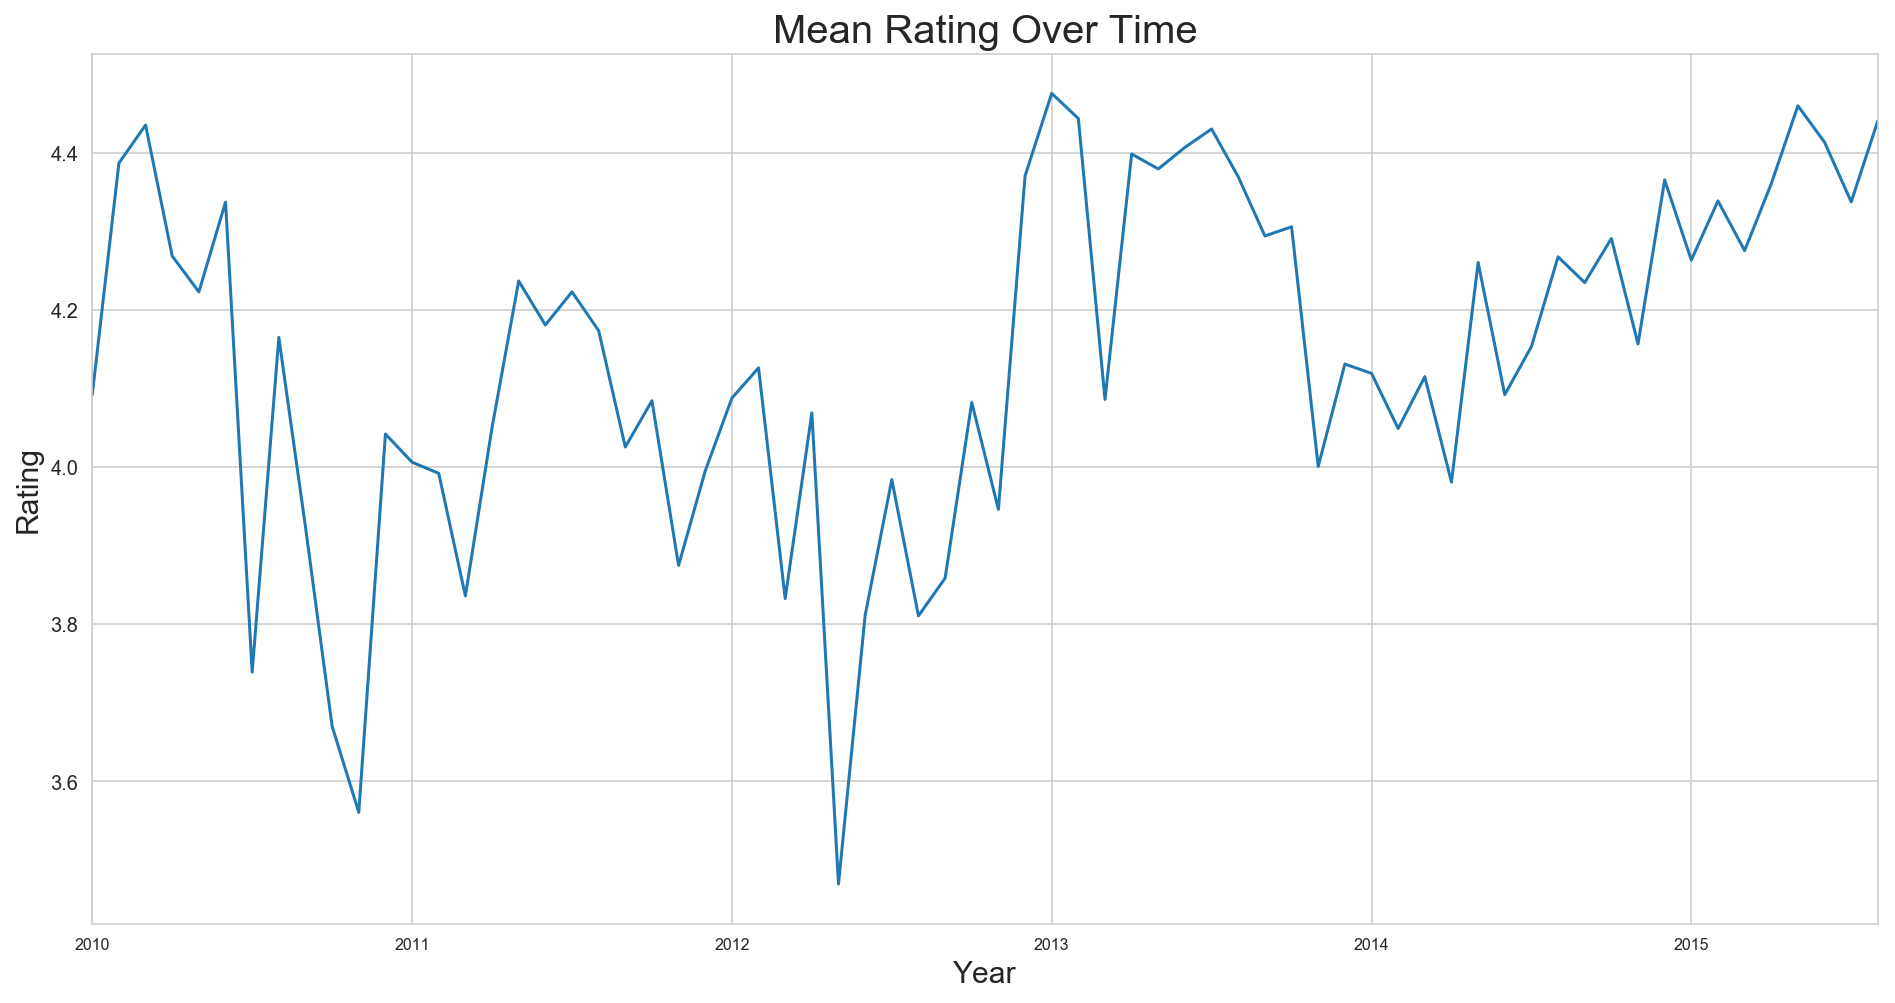

In [47]:
# Plot mean rating over time
rating_ym = amzn.groupby('year_month')['star_rating'].mean() 

rating_ym.plot(figsize=(16,8))
plt.title('Mean Rating Over Time', fontsize=20)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Rating', fontsize=15)
plt.xticks(fontsize=8)
plt.show()

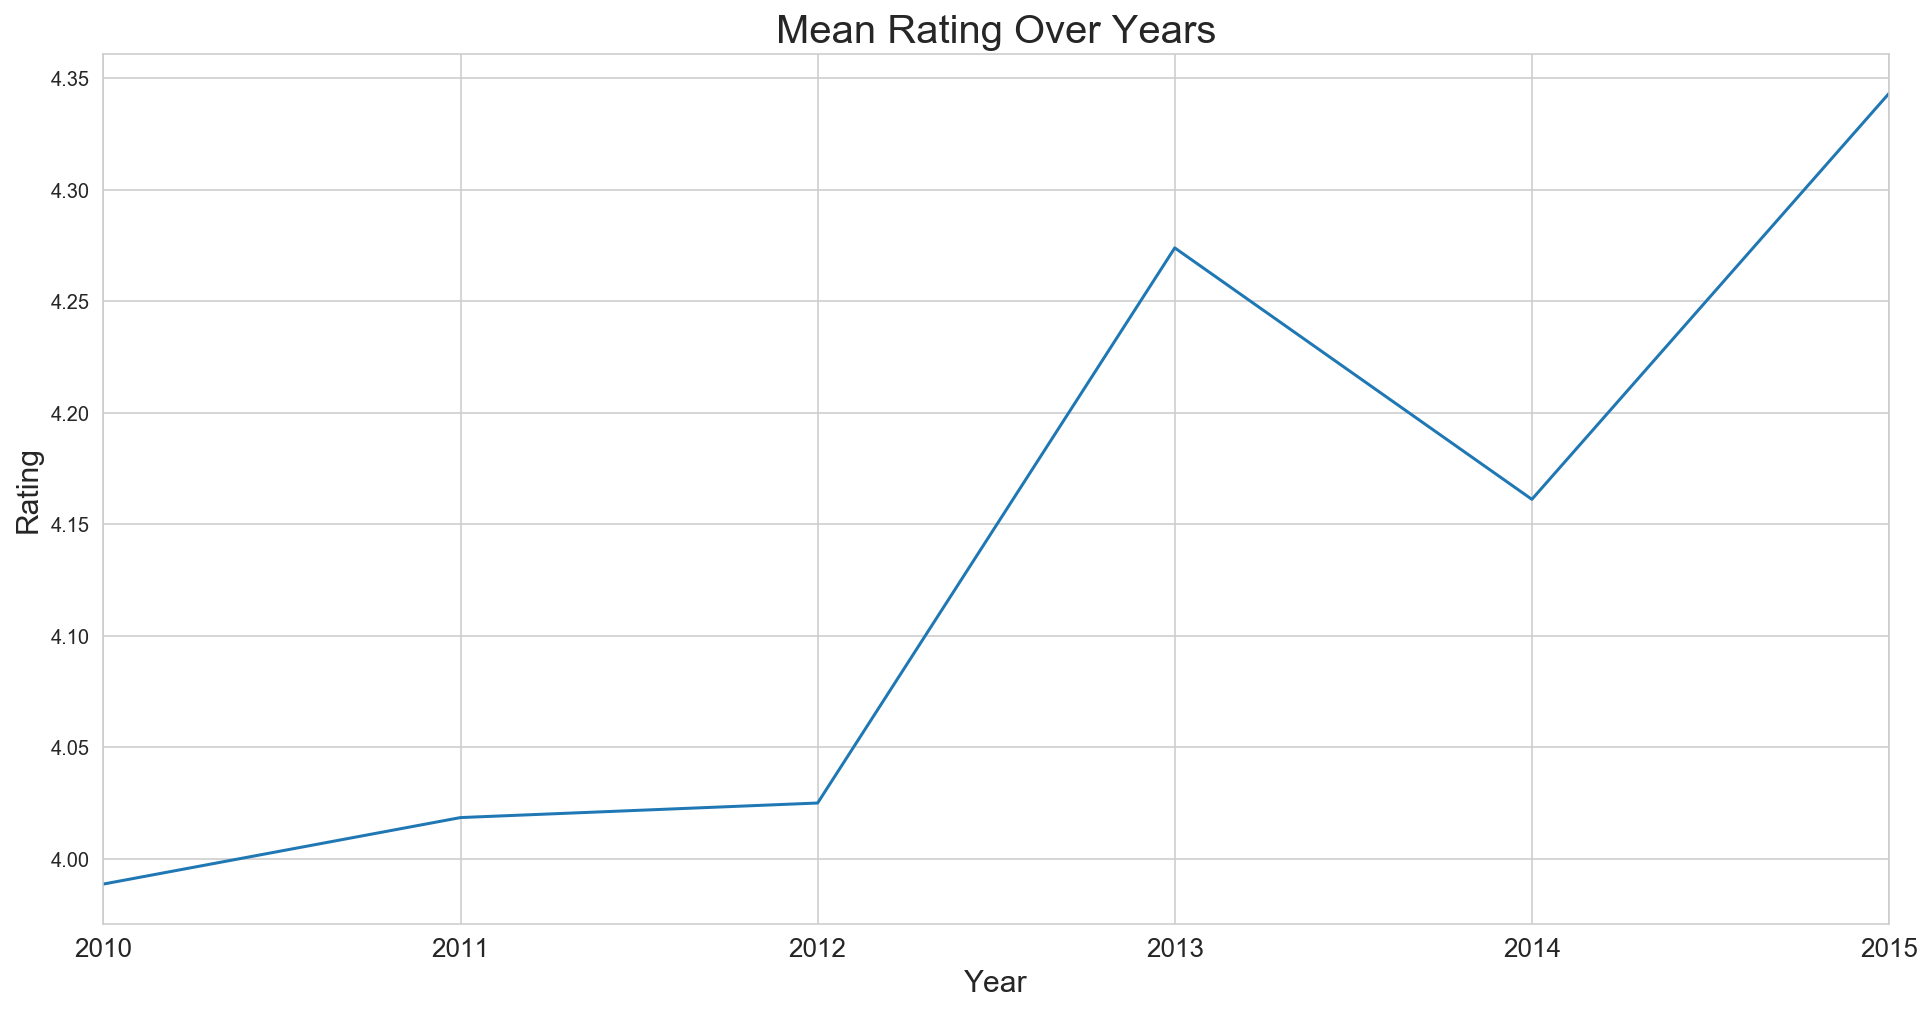

In [48]:
# Plot mean rating per year
years = amzn.groupby('year')['star_rating'].mean() 

years.plot(figsize=(16,8))
plt.title('Mean Rating Over Years', fontsize=20)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Rating', fontsize=15)
plt.xticks(fontsize=13)
plt.show()

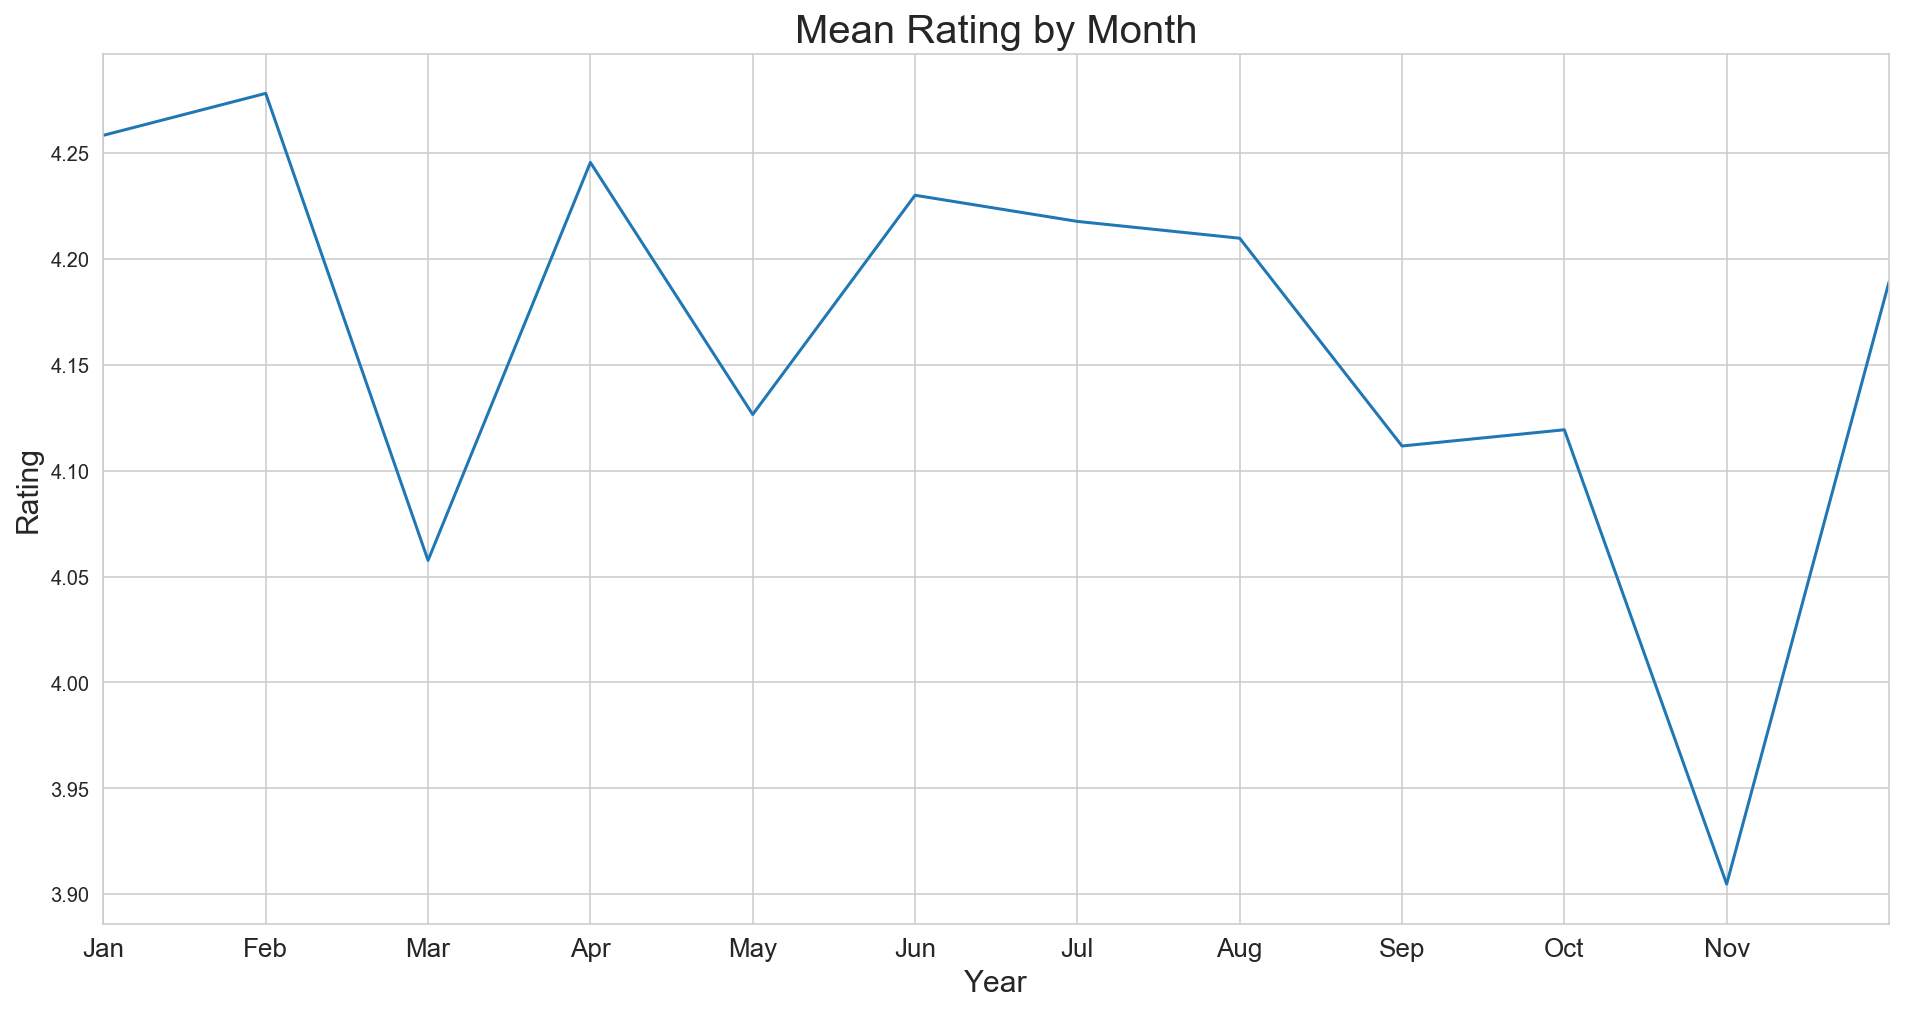

In [49]:
# Plot mean rating per month
months = amzn.groupby('month')['star_rating'].mean() 

months.plot(figsize=(16,8))
plt.title('Mean Rating by Month', fontsize=20)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Rating', fontsize=15)
plt.xticks(ticks=range(1,12), labels=['Jan','Feb','Mar','Apr','May','Jun',
                                      'Jul','Aug','Sep','Oct','Nov','Dec'], fontsize=13)
plt.show()

**Ratings for Games Time Series**

In [50]:
# Create a time series dataframe
item_ts = amzn.groupby(['product_title','year_month'])['star_rating'].mean().reset_index()

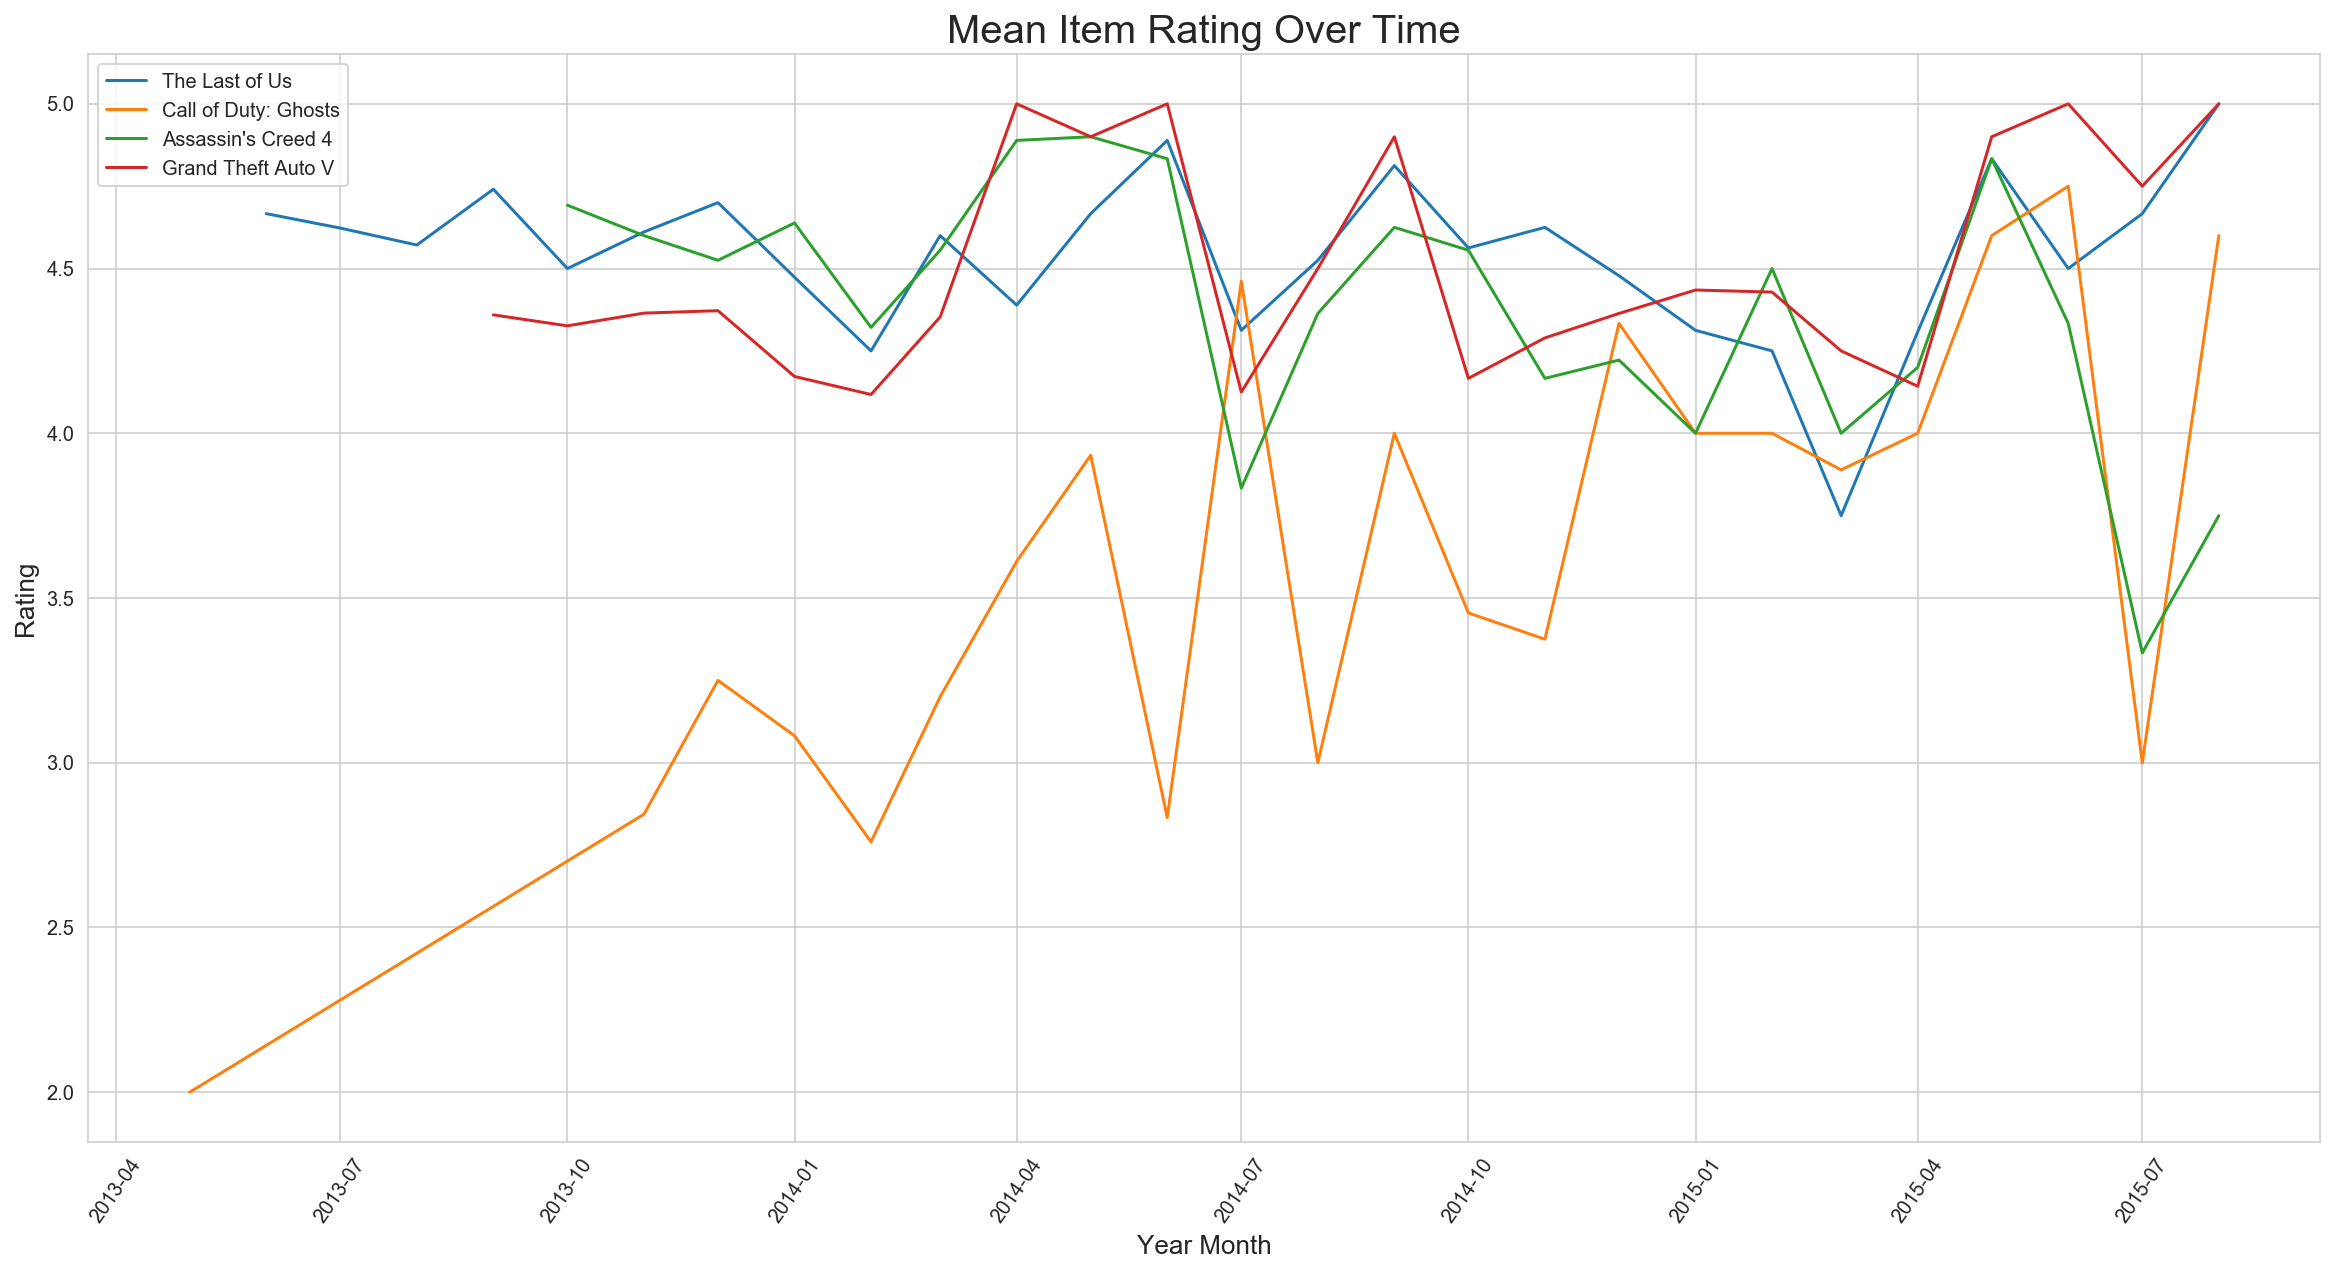

In [51]:
# Games between 2013 - 2015
tlos = item_ts[item_ts['product_title']=='The Last of Us'].sort_values(by='year_month', ascending=True)
cod = item_ts[item_ts['product_title']=='Call of Duty: Ghosts'].sort_values(by='year_month', ascending=True) 
ac4 = item_ts[item_ts['product_title']=="Assassin's Creed 4"].sort_values(by='year_month', ascending=True) 
gta5 = item_ts[item_ts['product_title']=='Grand Theft Auto V'].sort_values(by='year_month', ascending=True) 

plt.figure(figsize=(20,10))
plt.plot(tlos['year_month'], tlos['star_rating'], label='The Last of Us')
plt.plot(cod['year_month'], cod['star_rating'], label='Call of Duty: Ghosts')
plt.plot(ac4['year_month'], ac4['star_rating'], label="Assassin's Creed 4")
plt.plot(gta5['year_month'], gta5['star_rating'], label='Grand Theft Auto V')
plt.title('Mean Item Rating Over Time', fontsize=20)
plt.xlabel('Year Month', fontsize=13)
plt.ylabel('Rating', fontsize=13)
plt.xticks(rotation=55)
plt.legend()
plt.show()

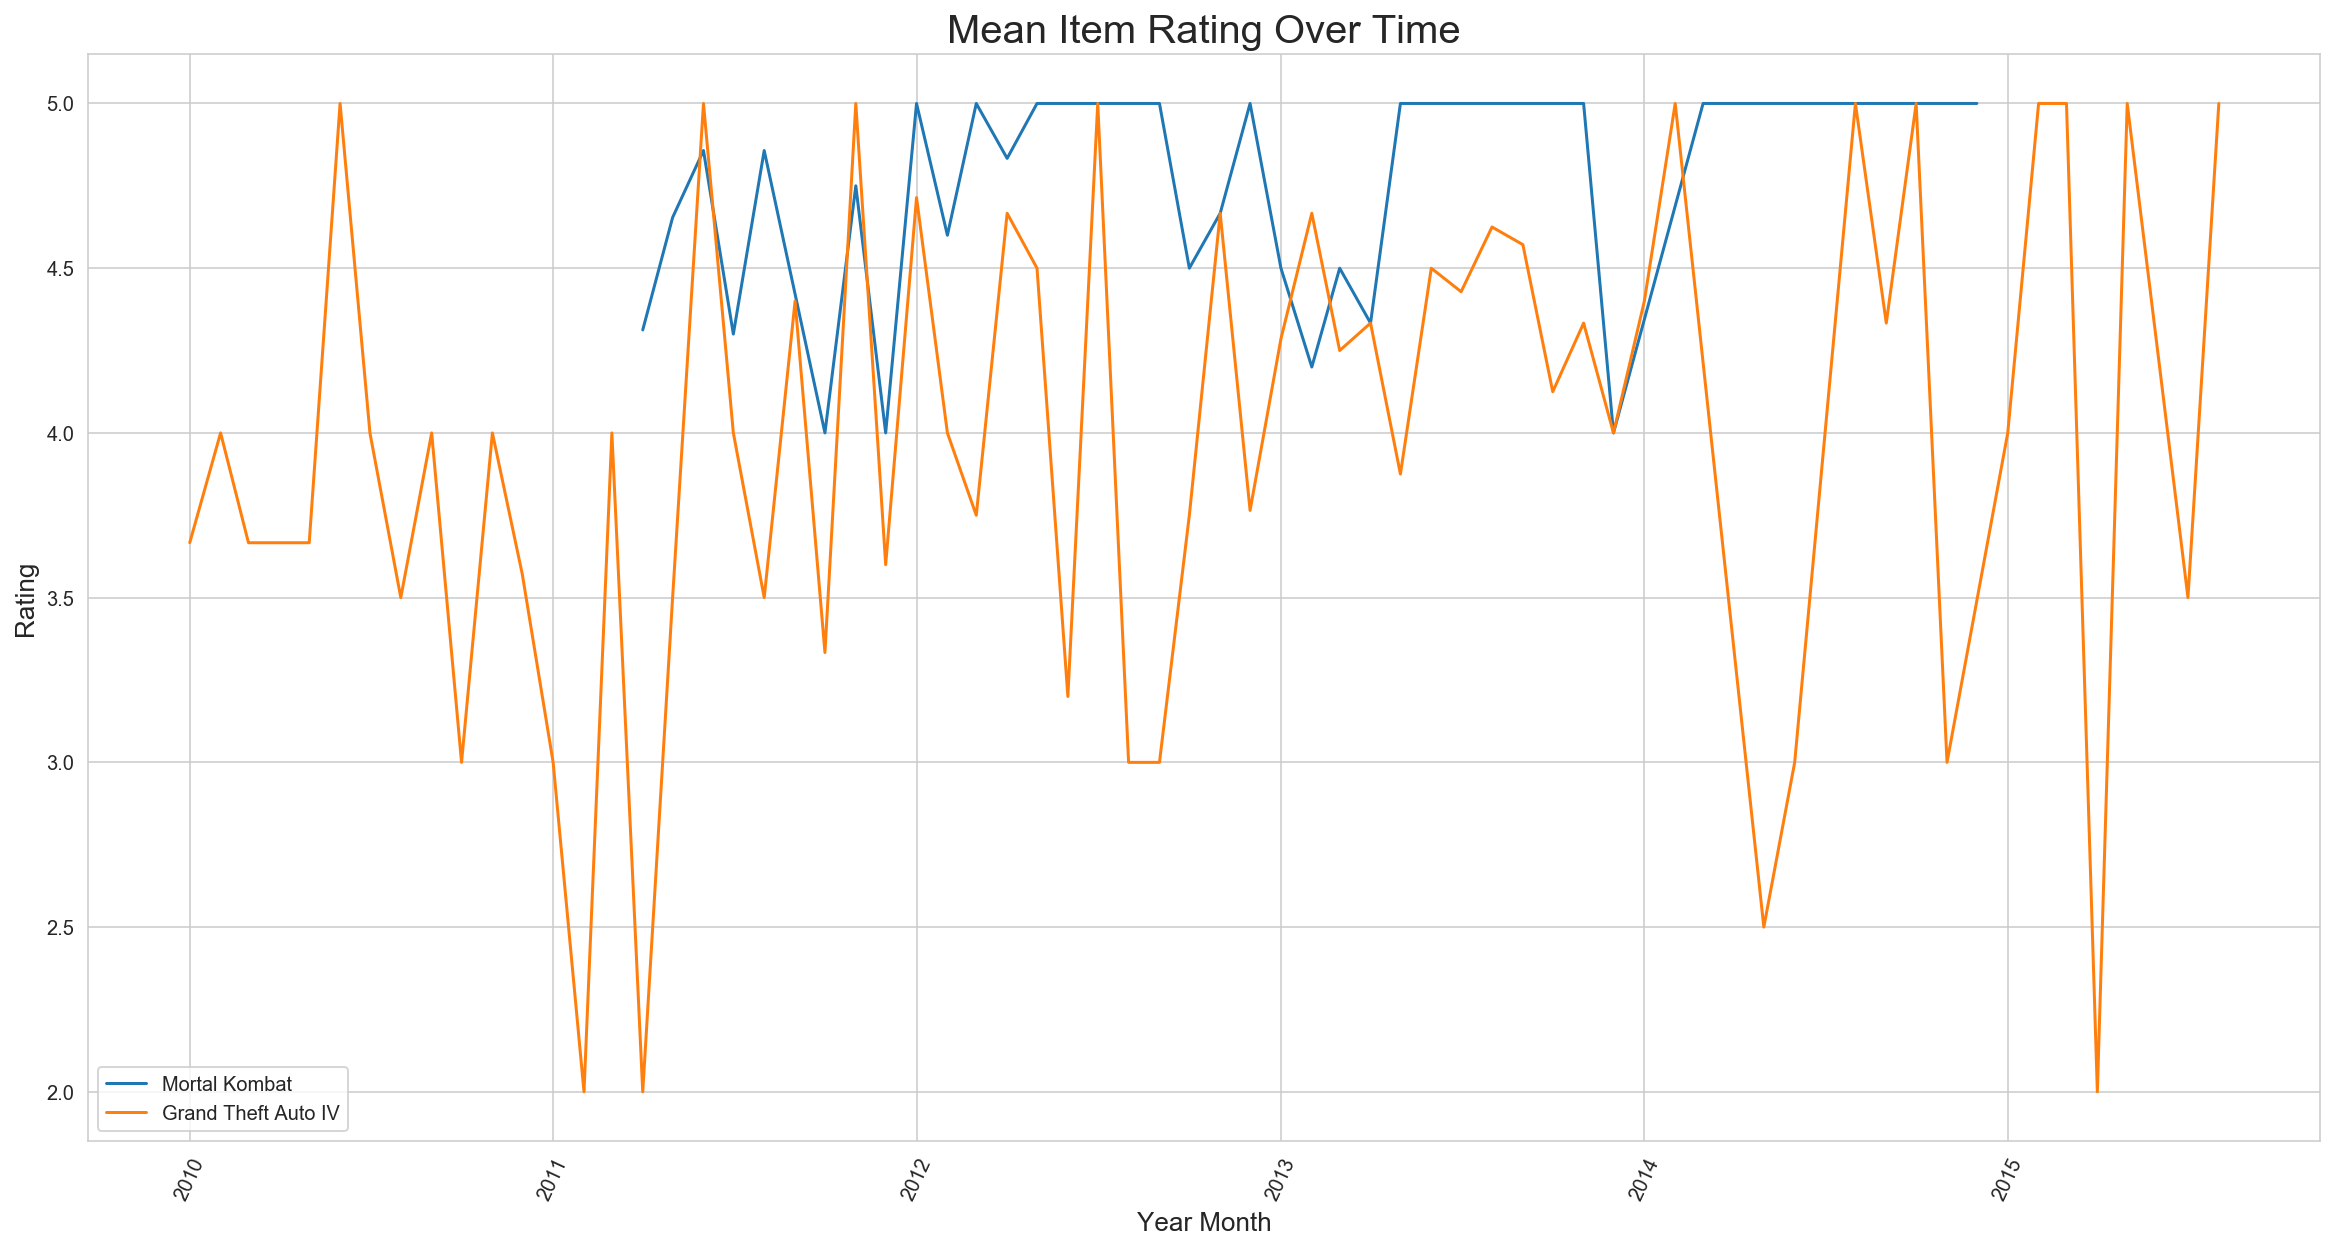

In [52]:
# Games between - 2002 - 2015
gta4 = item_ts[item_ts['product_title']=='Grand Theft Auto IV'].sort_values(by='year_month', ascending=True) 
mk = item_ts[item_ts['product_title']=='Mortal Kombat'].sort_values(by='year_month', ascending=True) 

plt.figure(figsize=(20,10))
plt.plot(mk['year_month'], mk['star_rating'], label='Mortal Kombat')
plt.plot(gta4['year_month'], gta4['star_rating'], label='Grand Theft Auto IV')
plt.title('Mean Item Rating Over Time', fontsize=20)
plt.xlabel('Year Month', fontsize=13)
plt.ylabel('Rating', fontsize=13)
plt.xticks(rotation=65)
plt.legend()
plt.show()

**Ratings for Customers Time Series**

In [53]:
# Create a time series dataframe
cust_ts = amzn.groupby(['customer_id','year_month'])['star_rating'].mean().reset_index()
cust_ts

,customer_id,year_month,star_rating
0,11049,2013-05-01,5.000000
1,11049,2014-08-01,5.000000
2,21299,2012-11-01,5.000000
3,21299,2013-11-01,5.000000
4,30719,2013-10-01,5.000000
5,30719,2013-11-01,5.000000
6,30719,2013-12-01,5.000000
7,31504,2013-01-01,5.000000
8,31504,2013-02-01,5.000000
9,35498,2012-11-01,5.000000


In [54]:
# # 2 most active customers
# first_cust = cust_ts[cust_ts['customer_id']==52759271].sort_values(by='year_month', ascending=True)
# second_cust = cust_ts[cust_ts['customer_id']==45838740].sort_values(by='year_month', ascending=True) 

# plt.figure(figsize=(20,10))
# plt.plot(first_cust['year_month'], first_cust['star_rating'], label='First')
# plt.plot(second_cust['year_month'], second_cust['star_rating'], label='Second')
# plt.title('Mean Customer Rating Over Time', fontsize=20)
# plt.xlabel('Year Month', fontsize=13)
# plt.ylabel('Rating', fontsize=13)
# plt.xticks(rotation=55)
# plt.legend()
# plt.show()

In [55]:
# # 3rd, 4th and 5th most active users
# third_cust = cust_ts[cust_ts['customer_id']==40955995].sort_values(by='year_month', ascending=True) 
# fourth_cust = cust_ts[cust_ts['customer_id']==24594001].sort_values(by='year_month', ascending=True)
# fifth_cust = cust_ts[cust_ts['customer_id']==48278407].sort_values(by='year_month', ascending=True)

# plt.figure(figsize=(20,10))
# plt.plot(third_cust['year_month'], third_cust['star_rating'], label='3rd', color='green')
# plt.plot(fourth_cust['year_month'], fourth_cust['star_rating'], label='4th', color='red')
# plt.plot(fifth_cust['year_month'], fifth_cust['star_rating'], label='5th', color='blue')
# plt.title('Mean Customer Rating Over Time', fontsize=20)
# plt.xlabel('Year Month', fontsize=13)
# plt.ylabel('Rating', fontsize=13)
# plt.xticks(rotation=55)
# plt.legend(loc='lower left')
# plt.show()

**Creating Train and Test Sets**

A metric used to in offline testing is recall score. The recall score of our model will tell us how many recommendations were a hit for customers, i.e. how successful our model is at recommending items to users that they actually bought. Thus, we will split our data into pre-2014 and 2014/2015 as our train and test sets respectively.

In [56]:
# Define train and test sets
trainset = amzn[amzn['year'] < 2014]
testset = amzn[amzn['year'] >= 2014]
print(trainset.shape)
print(testset.shape)

(28773, 19)
(4662, 19)


In [57]:
def train_test_check(trainset, testset):
    '''
    Function which takes in a train and test set and validates whether
    all test customers and products are also in the train set.
    '''
    for test_customer in testset['customer_id'].unique():
        if test_customer not in trainset['customer_id'].unique():
            print('{} is not in the train set'.format(test_customer))

    for test_product in testset['product_title'].unique():
        if test_product not in trainset['product_title'].unique():
            print('{} is not in the train set'.format(test_product))
            
    return 'If nothing was printed, all test customers and products are in the train set.'

In [58]:
train_test_check(trainset, testset)

'If nothing was printed, all test customers and products are in the train set.'

### 2.6. Review Body (Extra EDA - See if there is time to do anything with this)

In [74]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# Define stopwords
stopwords = list(ENGLISH_STOP_WORDS)
stopwords.extend(['game','games','like','new','play','time','really', 
                  'just', 'fun' 'good', 'great'])

# Apply a count vectorizer on the review body
cvec = CountVectorizer(stop_words=stopwords, max_features=500)
cvec.fit(amzn['review_body'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=500, min_df=1,
        ngram_range=(1, 1), preprocessor=None,
        stop_words=['anyone', 'both', 'can', 'cannot', 'ours', 'where', 'after', 'you', 'down', 'all', 'have', 'when', 'that', 'whenever', 'amount', 'only', 'had', 'perhaps', 'they', 'should', 'together', 'noone', 'anyhow', 'very', 'was', 'namely', 'before', 'almost', 'or', 'seemed', 'another', 'most', 'tho...'do', 'since', 'game', 'games', 'like', 'new', 'play', 'time', 'really', 'just', 'fungood', 'great'],
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [75]:
# Define X
X = pd.DataFrame(cvec.transform(amzn['review_body']).todense(), columns=cvec.get_feature_names())

In [76]:
# There are 55758 descriptions and 500 possible words in those files
X.shape

(33435, 500)

In [77]:
# Each column is a word and the value is the number of times that the word appears in the file
X.iloc[:5, 200:210]

,glitches,god,goes,going,gone,good,got,graphics,gta,guess
0,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0
2,0,0,1,2,0,0,1,1,0,0
3,0,0,0,2,1,3,0,0,0,2
4,0,0,0,0,0,2,0,1,0,0


In [78]:
# The 20 most common words amongst all reviews
X.sum().sort_values(ascending=False).head(20)


story       18118
fun         17884
good        17778
don         13647
playing     13336
played      12254
way         11113
graphics    10625
ve          10622
make        10052
better       9920
lot          9737
people       9717
best         9405
player       9154
want         8955
gameplay     8531
ll           8105
say          8022
love         7961
dtype: int64

/anaconda3/envs/Clone1/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


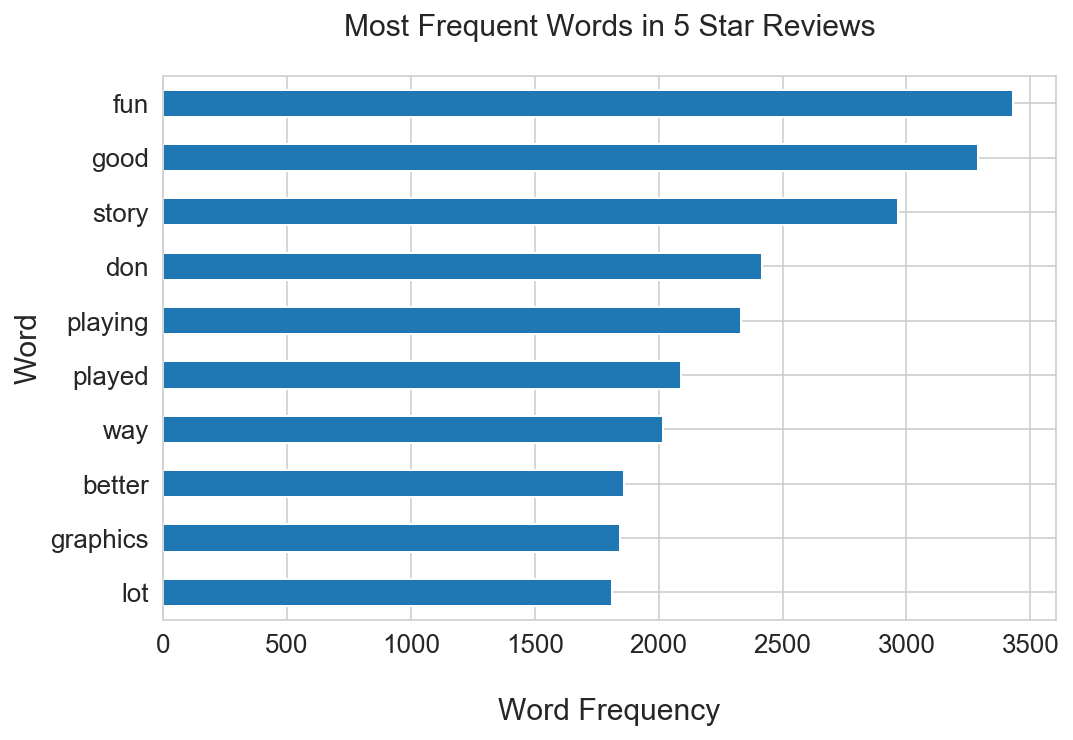

In [79]:
five_star_words = X.loc[amzn[amzn['star_rating']==5].index].sum(axis=0).sort_values(ascending=True)

five_star_words.tail(10).plot(kind='barh', figsize=(8,5))
plt.title('Most Frequent Words in 5 Star Reviews', pad=20, fontsize=15)
plt.xlabel('Word Frequency', labelpad=20, fontsize=15)
plt.ylabel('Word', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()

/anaconda3/envs/Clone1/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


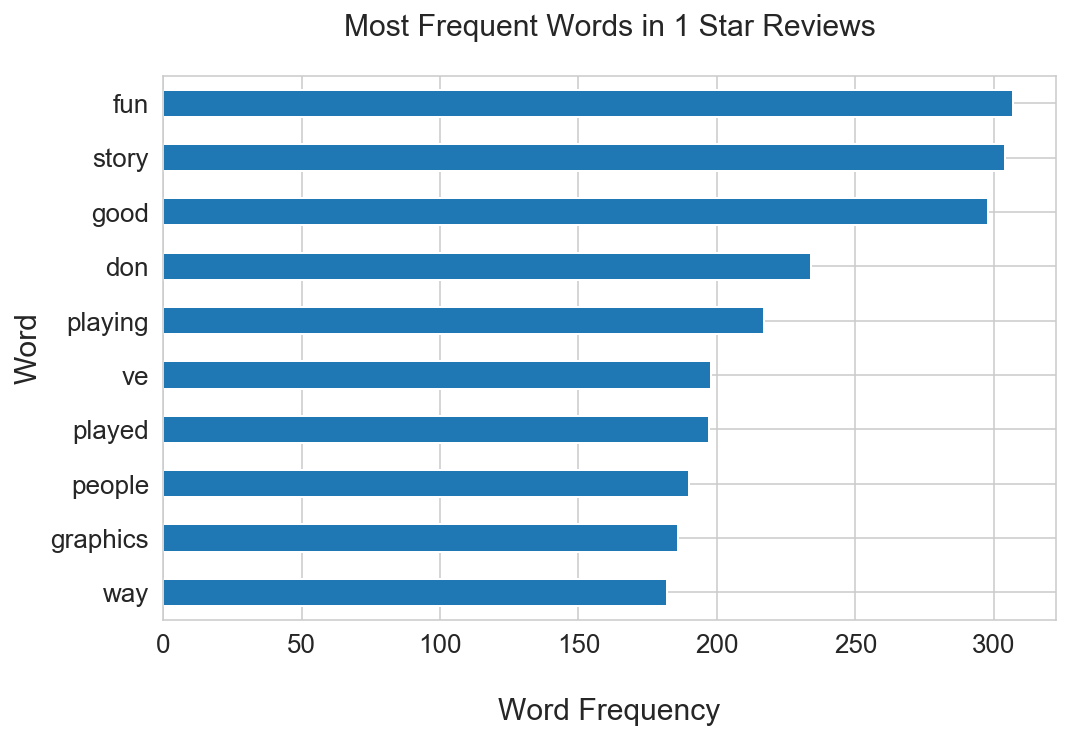

In [80]:
one_star_words = X.loc[amzn[amzn['star_rating']==1].index].sum(axis=0).sort_values(ascending=True)

one_star_words.tail(10).plot(kind='barh', figsize=(8,5))
plt.title('Most Frequent Words in 1 Star Reviews', pad=20, fontsize=15)
plt.xlabel('Word Frequency', labelpad=20, fontsize=15)
plt.ylabel('Word', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()

### 4. Save Cleaned Data

In [84]:
# Before saving, lets check the sparsity of our data
check_matrix_sparsity(amzn)

No. of unique users:  13271
No. of unique products:  221
Size of utility matrix: 13271 x 221; 2932891 cells
Sparsity: 1.140%


In [85]:
# No. of unique users:  13271
# No. of unique products:  221
# Size of utility matrix: 13271 x 221; 2932891 cells
# Sparsity: 1.140%

In [86]:
# Save to database
sqlite_db = 'datasets/amzn_vg_clean.db'
conn = sqlite3.connect(sqlite_db) 

amzn.to_sql('full_dataset', con=conn, if_exists='replace', index=False)
trainset.to_sql('trainset', con=conn, if_exists='replace', index=False)
testset.to_sql('testset', con=conn, if_exists='replace', index=False)

### 5. Metadata

In [88]:
import gzip

def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

df = getDF('datasets/meta_Video_Games.json.gz')

In [89]:
df.rename(columns={'asin':'product_id'}, inplace=True)
print(df.shape)
df.head()

(50953, 9)


,product_id,description,price,imUrl,related,salesRank,categories,title,brand
0,0078764343,Brand new sealed!,37.98,http://ecx.images-amazon.com/images/I/513h6dPb...,"{'also_bought': ['B000TI836G', 'B003Q53VZC', '...",{'Video Games': 28655},"[[Video Games, Xbox 360, Games]]",NaN,NaN
1,043933702X,In Stock NOW. Eligible for FREE Super Saving ...,23.50,http://ecx.images-amazon.com/images/I/61KKRndV...,"{'also_viewed': ['B000067NP1', '0439573947', '...",{'Video Games': 44080},"[[Video Games, PC, Games]]",NaN,NaN
2,0439339987,Grandma Groupers kelp seeds are missing and wi...,8.95,http://ecx.images-amazon.com/images/I/416QZg89...,"{'also_bought': ['B000314VVU', 'B000PXUOTE', '...",{'Video Games': 49836},"[[Video Games, PC, Games]]",NaN,NaN
3,0439342260,This software is BRAND NEW. Packaging may diff...,NaN,http://ecx.images-amazon.com/images/I/61Wvu-Uj...,{'also_viewed': ['043934302X']},{'Video Games': 49156},"[[Video Games, PC, Games]]",NaN,NaN
4,0439339960,a scholastic clubs fairs cd rom game,NaN,http://ecx.images-amazon.com/images/I/51k3oRCF...,{'also_viewed': ['B00028D7TG']},{'Video Games': 52262},"[[Video Games, PC, Games]]",NaN,NaN


In [90]:
# Merge with amzn dataset and drop title and brand columns
new = pd.merge(amzn, df, on='product_id')
new.drop(columns=['title','brand'], inplace=True)
new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32630 entries, 0 to 32629
Data columns (total 25 columns):
marketplace          32630 non-null object
customer_id          32630 non-null int64
review_id            32630 non-null object
product_id           32630 non-null object
product_parent       32630 non-null int64
product_title        32630 non-null object
product_category     32630 non-null object
star_rating          32630 non-null int64
helpful_votes        32630 non-null int64
total_votes          32630 non-null int64
vine                 32630 non-null object
verified_purchase    32630 non-null object
review_headline      32630 non-null object
review_body          32630 non-null object
review_date          32630 non-null datetime64[ns]
year_month           32630 non-null datetime64[ns]
year                 32630 non-null int64
month                32630 non-null int64
is_5_star            32630 non-null int64
description          32436 non-null object
price                32

In [92]:
all_cats = []
for big_list in new['categories']:
    for small_list in big_list:
        for item in small_list:
            all_cats.append(item)
            
unique_cats = Counter(all_cats)
unique_cats

Counter({'Video Games': 40059,
         'PlayStation 3': 13220,
         'Games': 37172,
         'Kids & Family': 6996,
         'Nintendo 3DS': 3339,
         'PlayStation 4': 1660,
         'PC': 2028,
         'Xbox 360': 12670,
         'Toys & Games': 1352,
         'Electronics for Kids': 1352,
         'Plug & Play Video Games': 510,
         'Nintendo DS': 1042,
         'Wii': 3308,
         'Accessories': 190,
         'Controllers': 190,
         'Dance Mats': 190,
         'Wii U': 468,
         'Xbox One': 581,
         'More Systems': 867,
         'PlayStation 2': 344,
         'Xbox': 145,
         'GameCube': 207,
         'PlayStation': 48,
         'Nintendo 64': 113,
         'Sports & Outdoors': 287,
         'Fan Shop': 231,
         'Video Games & Accessories': 231,
         'Mac': 72,
         'Team Sports': 56,
         'Electronics': 78,
         'Computers & Accessories': 78,
         'Cables & Accessories': 61,
         'Video Projector Accessories': 61,
  

In [93]:
to_remove = ['Video Games',
             'Games', 
             'Kids & Family',
             'Toys & Games',
             'Electronics for Kids',
             'Accessories',
             'Controllers',
             'Dance Mats',
             'Sports & Outdoors',
             'Fan Shop',
             'Video Games & Accessories',
             'Team Sports',
             'Electronics',
             'Computers & Accessories',
             'Cables & Accessories',
             'Video Projector Accessories',
             'Lamps',
             'Football',
             'Consoles',
             'Computer Components']

for cat in to_remove:
    del unique_cats[cat]


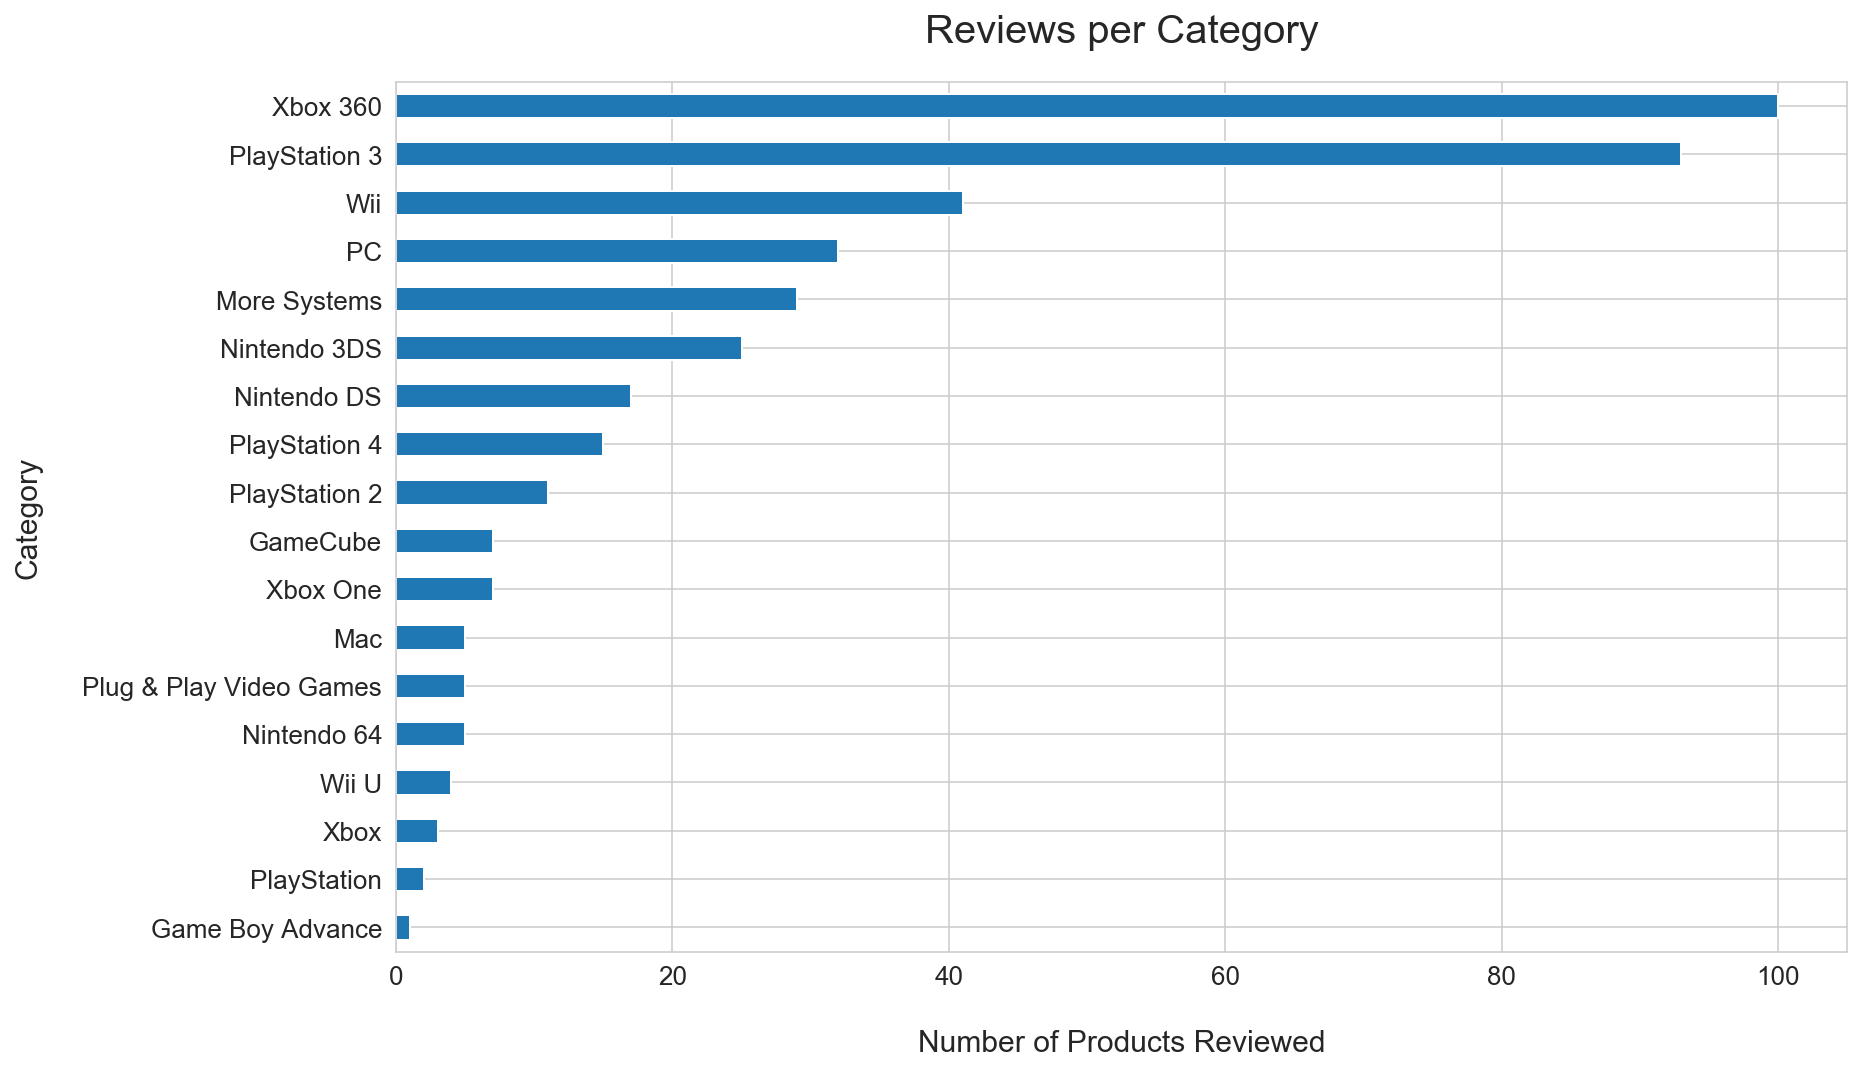

In [154]:
categories = [l for l, _ in unique_cats.items()]
values = [val for _, val in unique_cats.items()]

cat_pop = {'categories': [l for l, _ in unique_cats.items()], 
           'values': [val for _, val in unique_cats.items()]}

cat_df = pd.DataFrame(cat_pop).sort_values(by='values', ascending=True).set_index('categories')

cat_df.plot(kind='barh', figsize=(13,8), legend=None)
plt.title('Reviews per Category', pad=20, fontsize=20)
plt.xlabel('Number of Products Reviewed', labelpad=20, fontsize=15)
plt.ylabel('Category', labelpad=20, fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()


In [96]:
# This table will be stored in a database for the webapp
products_df = new[['product_id','product_title','price','star_rating','categories','imUrl']].copy()
products_df = products_df.groupby('product_id').mean().reset_index()
print(products_df.shape)
products_df.head()

(284, 5)


,product_id,product_title,price,categories,imUrl
0,B00000DMAT,GoldenEye 007,249.98,"[[Video Games, More Systems, Nintendo 64, Games]]",http://ecx.images-amazon.com/images/I/414QkxMt...
1,B00000DMB3,The Legend of Zelda: Ocarina of Time,39.99,"[[Video Games, Kids & Family], [Video Games, M...",http://ecx.images-amazon.com/images/I/51manK99...
2,B00000F1GM,Super Mario 64,299.99,"[[Video Games, Kids & Family], [Video Games, M...",http://ecx.images-amazon.com/images/I/51HJDRbM...
3,B00000K4MC,Roller Coaster Tycoon,14.99,"[[Video Games, Kids & Family], [Video Games, P...",http://ecx.images-amazon.com/images/I/61KTPYDH...
4,B00001IVRD,StarCraft Battle Chest,19.99,"[[Video Games, Mac, Games], [Video Games, PC, ...",http://ecx.images-amazon.com/images/I/711YV9XN...


**Clean up Categories Column**

In [104]:
# Get all categories again for refined data
all_cats = []
for big_list in products_df['categories']:
    for small_list in big_list:
        for item in small_list:
            all_cats.append(item)
            
unique_cats = Counter(all_cats)

# Get rid of the non-game categories
to_remove = ['Video Games',
             'Games', 
             'Kids & Family',
             'Toys & Games',
             'Electronics for Kids',
             'Accessories',
             'Controllers',
             'Dance Mats',
             'Sports & Outdoors',
             'Fan Shop',
             'Video Games & Accessories',
             'Team Sports',
             'Electronics',
             'Computers & Accessories',
             'Cables & Accessories',
             'Video Projector Accessories',
             'Lamps',
             'Football',
             'Consoles',
             'Computer Components']

for cat in to_remove:
    del unique_cats[cat]

sorted(unique_cats.items(), key=lambda kv: kv[1], reverse=True)

[('Xbox 360', 100),
 ('PlayStation 3', 93),
 ('Wii', 41),
 ('PC', 32),
 ('More Systems', 29),
 ('Nintendo 3DS', 25),
 ('Nintendo DS', 17),
 ('PlayStation 4', 15),
 ('PlayStation 2', 11),
 ('GameCube', 7),
 ('Xbox One', 7),
 ('Nintendo 64', 5),
 ('Mac', 5),
 ('Plug & Play Video Games', 5),
 ('Wii U', 4),
 ('Xbox', 3),
 ('PlayStation', 2),
 ('Game Boy Advance', 1)]

In [151]:
# Functions to get the category of the game
def get_category(x):
    for cat_lst in x:
        for cat in cat_lst:
            if cat=='Video Games' or cat=='More Systems' or cat=='Mac' or cat=='Kids & Family' or cat=='Games' or cat=='Sports & Outdoors' or cat=='Electronics' or cat=='Toys & Games' or cat=='Electronics for Kids' or cat=='Computers & Accessories' or cat=='Fan Shop' or cat=='Team Sports' or cat=='Cables & Accessories' or cat=='Plug & Play Video Games' or cat=='Video Games & Accessories' or cat=='Football' or cat=='Computer Components' or cat=='Video Projector Accessories' or cat=='Lamps': 
                pass 
            elif cat == 'Xbox 360': 
                return 'Xbox 360'
            elif cat == 'Xbox One': 
                return 'Xbox One'
            elif cat == 'Xbox': 
                return 'Xbox'
            elif cat == 'PlayStation 3':
                return 'PlayStation 3'
            elif cat == 'PlayStation 4':
                return 'PlayStation 4'
            elif cat == 'PlayStation 2':
                return 'PlayStation 2'
            elif cat == 'PlayStation':
                return 'PlayStation'            
            elif cat == 'PC':
                return 'PC'
            elif cat == 'GameCube':
                return 'GameCube'
            elif cat == 'Wii':
                return 'Wii'
            elif cat == 'Wii U':
                return 'Wii U'
            elif cat == 'Nintendo 64':
                return 'Nintendo 64'
            elif cat == 'Game Boy Advance':
                return 'Game Boy Advance'
            elif cat == 'Nintendo DS':
                return 'Nintendo DS'
            elif cat == 'Nintendo 3DS':
                return 'Nintendo 3DS'
            else:
                print(cat)
                return 'Other'

def apply_col(col):
    return col.apply(get_category)

In [155]:
# Make category column
products_df['category'] = products_df['categories'].apply(get_category)
products_df.drop(columns='categories', inplace=True)
products_df

,product_id,product_title,price,imUrl,category
0,B00000DMAT,GoldenEye 007,249.98,http://ecx.images-amazon.com/images/I/414QkxMt...,Nintendo 64
1,B00000DMB3,The Legend of Zelda: Ocarina of Time,39.99,http://ecx.images-amazon.com/images/I/51manK99...,Nintendo 64
2,B00000F1GM,Super Mario 64,299.99,http://ecx.images-amazon.com/images/I/51HJDRbM...,Nintendo 64
3,B00000K4MC,Roller Coaster Tycoon,14.99,http://ecx.images-amazon.com/images/I/61KTPYDH...,PC
4,B00001IVRD,StarCraft Battle Chest,19.99,http://ecx.images-amazon.com/images/I/711YV9XN...,PC
5,B00002CF9M,Diablo 2,19.99,http://ecx.images-amazon.com/images/I/510DCD2K...,PC
6,B00002STGL,Perfect Dark,49.90,http://ecx.images-amazon.com/images/I/71fzEw4A...,Nintendo 64
7,B00004S9AF,The Legend of Dragoon - Playstation,126.92,http://ecx.images-amazon.com/images/I/61VSBSPl...,PlayStation 2
8,B00004TC6E,Chrono Cross - PlayStation,47.11,http://ecx.images-amazon.com/images/I/51iVctuK...,PlayStation
9,B00004U1R1,The Legend of Zelda: Majora's Mask,160.02,http://ecx.images-amazon.com/images/I/41g0ABlY...,Nintendo 64


In [156]:
# Lets take a look at the value counts again
products_df['category'].value_counts()

Xbox 360            81
PlayStation 3       76
PC                  31
Wii                 24
Nintendo 3DS        14
PlayStation 2       11
PlayStation 4       10
Nintendo DS          7
GameCube             7
Xbox One             6
Nintendo 64          5
Xbox                 3
Wii U                2
Game Boy Advance     1
PlayStation          1
Name: category, dtype: int64

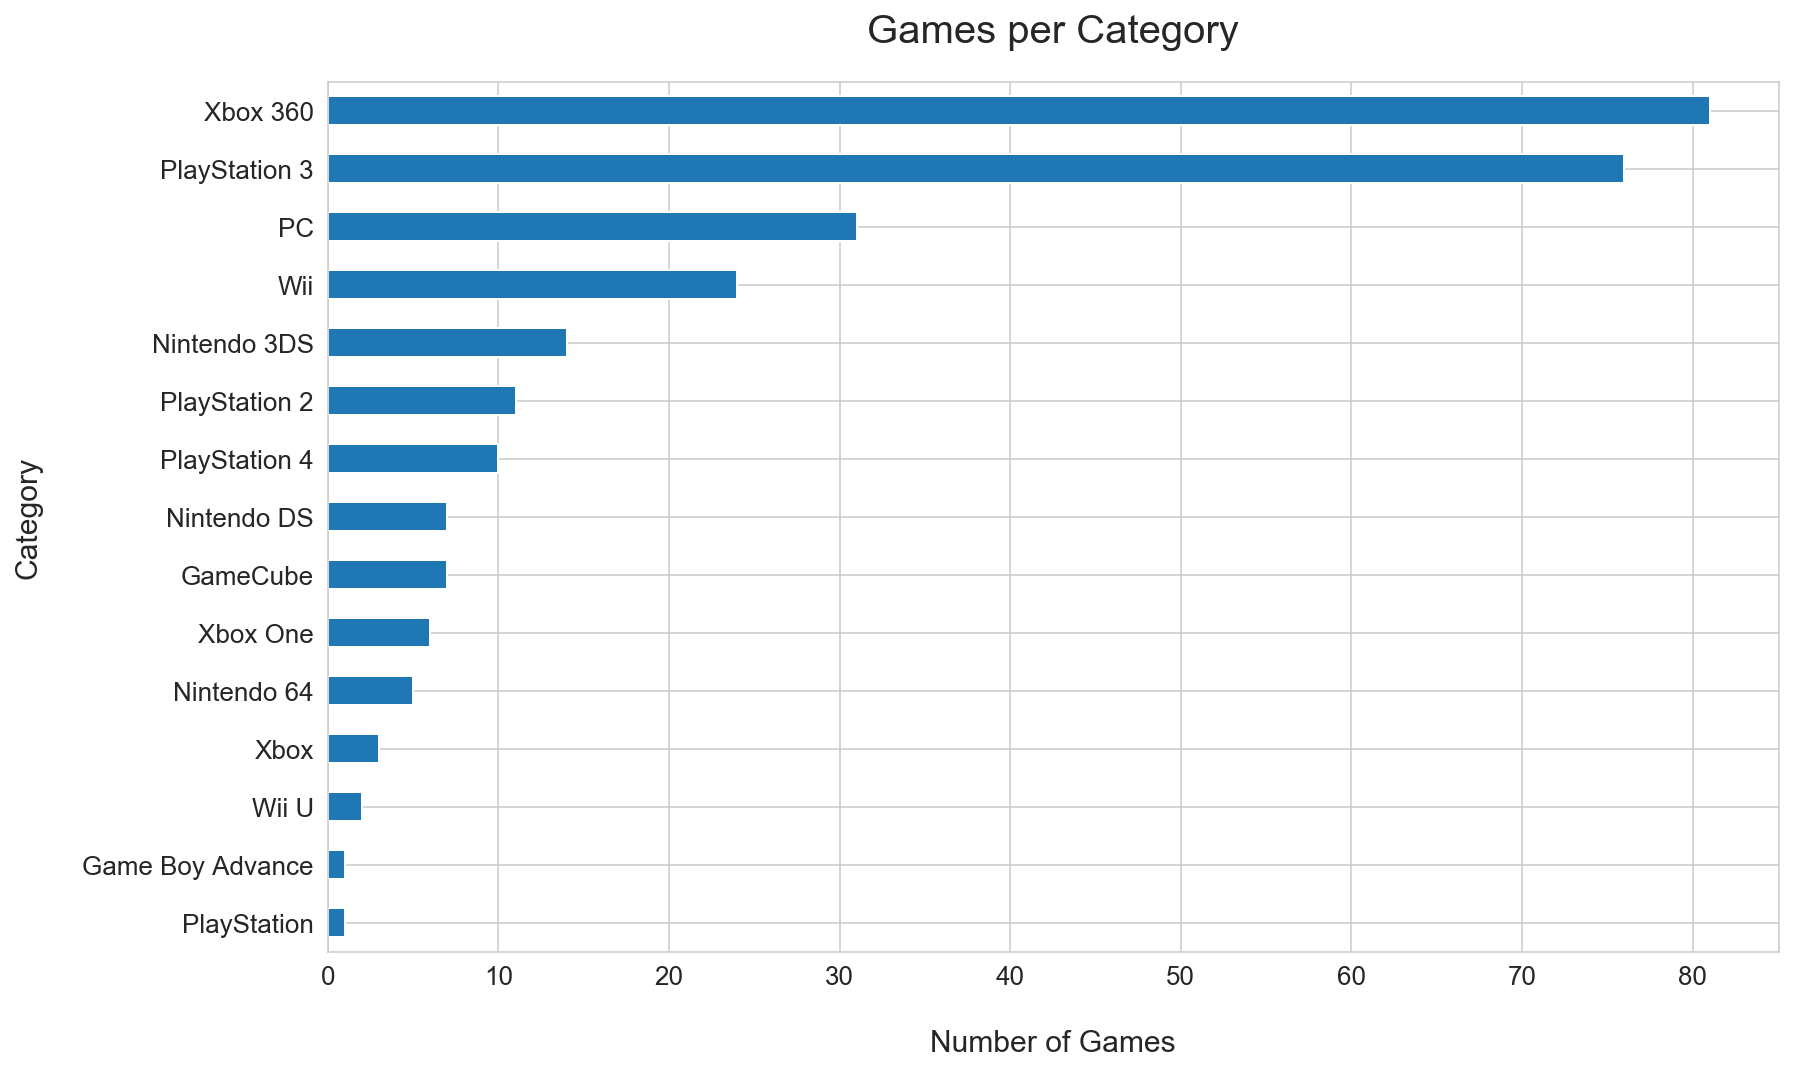

In [161]:
products_df['category'].value_counts(ascending=True).plot(kind='barh', figsize=(13,8), legend=None)
plt.title('Games per Category', pad=20, fontsize=20)
plt.xlabel('Number of Games', labelpad=20, fontsize=15)
plt.ylabel('Category', labelpad=20, fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()

**Make Final Merge**

In [157]:
# Let's add a times reviewed column
unique_products = new.groupby('product_id')[['product_id','product_title']].size().sort_values(ascending=False)
unique_products = unique_products.reset_index()
unique_products.columns = ['product_id','times_reviewed']
unique_products.head()

,product_id,times_reviewed
0,B007CM0K86,582
1,B0050SYX8W,479
2,B007XVTR3K,406
3,B004EQCCI4,405
4,B004HYK956,391


In [158]:
# Final Merge
products = pd.merge(products_df, unique_products).sort_values(by='times_reviewed', ascending=False)
products.head()

,product_id,product_title,price,imUrl,category,times_reviewed
215,B007CM0K86,The Last of Us,39.00,http://ecx.images-amazon.com/images/I/61WVjDOz...,PlayStation 3,582
194,B0050SYX8W,Halo 4,29.99,http://ecx.images-amazon.com/images/I/51KA8qJI...,Xbox 360,479
222,B007XVTR3K,Call of Duty: Black Ops II,41.44,http://ecx.images-amazon.com/images/I/51l-1nn%...,Xbox 360,406
157,B004EQCCI4,Uncharted 3: Drake's Deception,19.99,http://ecx.images-amazon.com/images/I/612lZQdr...,PlayStation 3,405
164,B004HYK956,Elder Scrolls V: Skyrim,19.99,http://ecx.images-amazon.com/images/I/413Gdr3F...,Xbox 360,391


In [159]:
# Save to db
products.to_sql('products', con=conn, if_exists='replace', index=False)